# Analysis of forward flight

## Import statements and notebook settings

In [66]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

import seaborn as sns

from tools.helper_functions import moving_average, normalize, rolling_normal
from tools.data_loader import load_flight_data, select_sequence, clean_data, apply_motor_calibration

import tools.data_loader as dl

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from scipy import stats

import glob
import os

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# declare ALL list objects necessary

v_induced = 14.345219306215128 # induced velocity for firefly vehicle
markersize= 15 # global markersize setting for scatter plots

# set colors

lowCol = '#FF7518' # pumpkin orange
upCol = '#18A2FF' # complementary color


upMeanCol = 'blue'
lowMeanCol = 'black'

armCol = upCol
armMeanCol = 'red'

## Load flight data

In [69]:
# select test flight

# first testflight
#flight = f'../flight_data/2022-08-01_ag_field/flight_6_first_hover_flight/'
#hoverStart = 35
#hoverEnd = 15

# second testflight
#flight = f'../flight_data/2022-08-01_ag_field/flight_8_second_hover_flight/'
#hoverStart = 30
#hoverEnd = 190

## third testflight
#flight = f'../flight_data/2022-08-29_ag_field/flight_2_delta0_sweep/'
#hoverStart = 100
#hoverEnd = 510

# forward flight
#flight = f'../flight_data/2022-10-10_ag_field/flight_1/'
#flight = f'../flight_data/2022-10-10_ag_field/flight_2_aborted_after_first_delta0_step/'
#hoverStart = 0
#hoverEnd = 90

# 21-10 flight test
## third testflight
#flight = f'../flight_data/2022-10-21_ag_field/flight_0/'

# 11-09 test flight
#flight = f'../flight_data/2022-11-09_ag_field/flight_1_mission_7.5ms/'
#flight = f'../flight_data/2022-11-09_ag_field/flight_2_mission_10ms_heavy/'
flight = f'../flight_data/2022-11-09_ag_field/test/'

hoverStart = 95
hoverEnd = 150

In [70]:
fd = load_flight_data(flight)
fd = dl.convert_time(fd)

In [71]:
fd.keys()

Index(['t', 'x', 'y', 'z', 'u', 'v', 'w', 'p', 'q', 'r', 'U11', 'U12', 'U13',
       'U14', 'U15', 'U16', 'U17', 'U18', 'I11', 'I12', 'I13', 'I14', 'I15',
       'I16', 'I17', 'I18', 'omega1', 'omega2', 'omega3', 'omega4', 'omega5',
       'omega6', 'omega7', 'omega8', 'thr_in1', 'thr_in2', 'thr_in3',
       'thr_in4', 'thr_in5', 'thr_in6', 'thr_in7', 'thr_in8', 'thr_out1',
       'thr_out2', 'thr_out3', 'thr_out4', 'thr_out5', 'thr_out6', 'thr_out7',
       'thr_out8', 'time_boot_ms', 'status', 'nooutputs', 'ctrl_1', 'ctrl_2',
       'ctrl_3', 'ctrl_4', 'ctrl_5', 'ctrl_6', 'ctrl_7', 'ctrl_8', 'output1',
       'output2', 'output3', 'output4', 'output5', 'output6', 'output7',
       'output8', 'pwm_1', 'pwm_2', 'pwm_3', 'pwm_4', 'pwm_5', 'pwm_6',
       'pwm_7', 'pwm_8', 'delta_1', 'delta_2', 'delta_3', 'delta_4', 'delta_5',
       'delta_6', 'delta_7', 'delta_8', 'nsh[0]', ' nsh[1]'],
      dtype='object')

## Preprocessing

### Rename columns and calculate power values for motors, arms and vehicle

In [72]:
fd = clean_data(fd)

### Apply calibration for ESC current and voltage

In [73]:
fd = apply_motor_calibration(fd)

### Correct current signal for motor 3

For unknown reasons the current sensor of motor 3 is not capable of detecting values below 2.66 A. This can lead to a bias in the power signal for motor 3. For this reason, we perform a linear regression for current and RPM signal, as the RPM signal is considered more reliable. All values below 2.66 A are replaced with the predictions for the RPM value  

In [74]:
# Perform regression RPM vs. current

rpm_range = np.linspace(0, 3000, 100).reshape(-1,1)
currentRegMotorValues = []
currentRegCurve = []
fd_current = []


for i in range(1,9):
    
    # get all points where I3 has its minimum value and RPM is greater than 0
    filtered = fd[fd[f'I{i}']> fd[f'I{i}'].min()]
    filtered = filtered[filtered[f'rpm{i}']> 0]
    
    rpm = filtered[[f'rpm{i}']]
    current = filtered[[f'I{i}']]
    
    rpmAsPolynomial = PolynomialFeatures(degree=3, include_bias=False).fit_transform(rpm)
    
    currentRegression = LinearRegression(fit_intercept=False, positive=True).fit(rpmAsPolynomial, current)

    rpmRangePolynomial = PolynomialFeatures(degree=3, include_bias=False).fit_transform(rpm_range)
    
    currentPredictions = currentRegression.predict(rpmRangePolynomial)
    
    currentRegMotorValues.append(currentPredictions)
    fd_current.append(filtered)
    currentRegCurve.append(currentRegression)

In [75]:
# correct values for current by using regression model

# save value of flight data DataFrame
#fd_corrected = fd.copy()
fd_old = fd.copy(deep=True)

# get indices where I3 is minimum
minI3 = fd['I3']==fd[f'I3'].min()
rpm3Data = fd['rpm3'][minI3].values.reshape(-1,1)

# transform polynomial features
rpm3Features = PolynomialFeatures(degree=3, include_bias=False).fit_transform(rpm3Data)

# perform regression
rpm3RegressionResult = currentRegCurve[2].predict(rpm3Features).reshape(-1)

# apply correction to current signal
fd.loc[minI3,'I3'] = rpm3RegressionResult

<IPython.core.display.Javascript object>


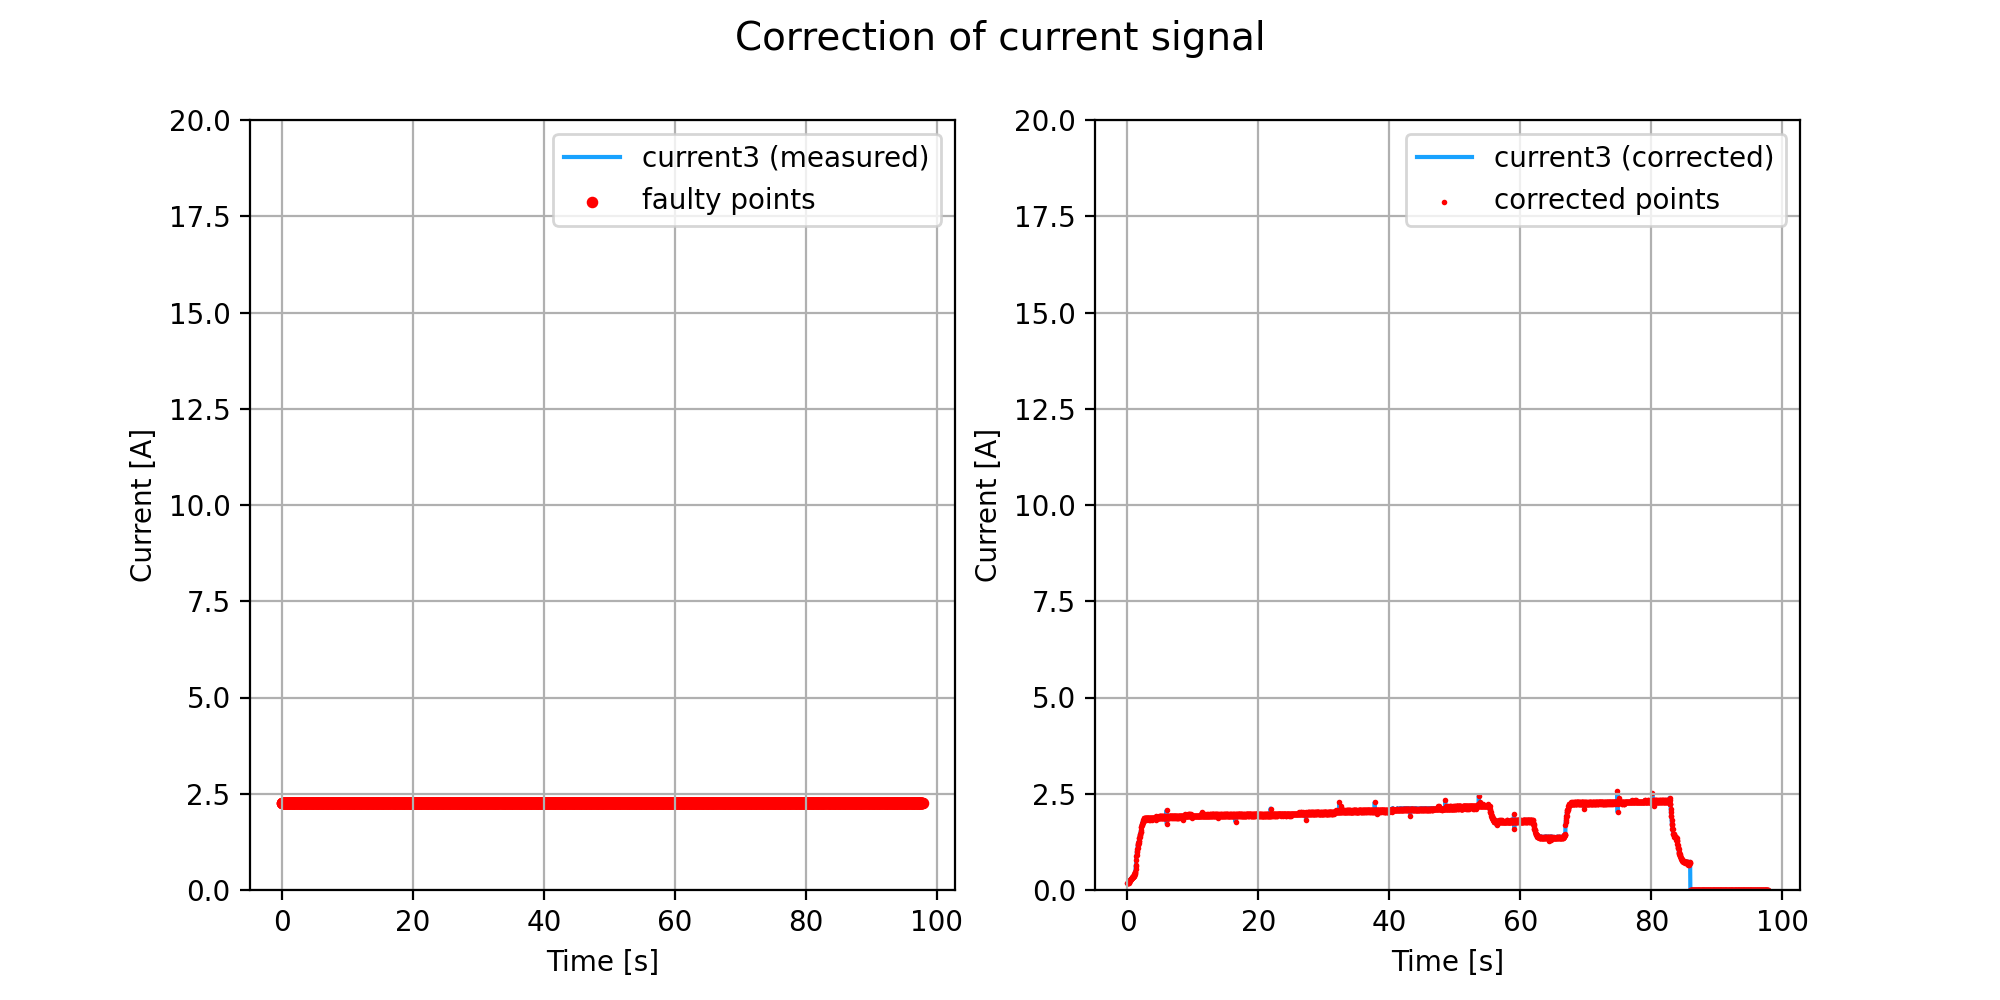

In [76]:
figCurrent, axCurrent = plt.subplots(1,2, figsize=(10,5))
figCurrent.suptitle("Correction of current signal", fontsize=14)

# plot current over time for motor 3
axCurrent[0].plot(fd_old['t'], fd_old['I3'], color=upCol, label='current3 (measured)', zorder=1)

# mark points that will replaced with red color
axCurrent[0].scatter(fd_old['t'][minI3], fd_old['I3'][minI3], color='r', s=10, label='faulty points')

# plot corrected current over time
axCurrent[1].plot(fd['t'], fd['I3'], color=upCol, label='current3 (corrected)', zorder=1)

# mark points that were replaced with red color
axCurrent[1].scatter(fd['t'][minI3], fd['I3'][minI3], color='r', s=1, label='corrected points')

for i in range(2):
    axCurrent[i].set_xlabel('Time [s]')
    axCurrent[i].set_ylabel('Current [A]')
    axCurrent[i].set_ylim(0,20)
    axCurrent[i].grid()
    axCurrent[i].legend()


### Calculate power and controls

In [77]:
fd = dl.calculate_power_and_rpm(fd)

### Calculate motor commands

In [78]:
fd = dl.calculate_motor_cmds(fd)

### Remove values during transition from hover to forward flight

In [79]:
from scipy.signal import argrelextrema

In [80]:
fd['du'] = (fd['u'].diff() / fd['t'].diff())
fd['duMean'] = (fd['u'].diff() / fd['t'].diff()).rolling(5,1).mean()
localMax = argrelextrema(fd['duMean'].values, np.greater, order=100)
localMax = np.intersect1d(localMax, fd[fd['duMean']>3].index)
localMin = argrelextrema(fd['duMean'].values, np.less, order=600)[0]
#localMin = np.intersect1d(localMin, fd[fd['duMean']>3].index)

In [81]:
fdUnfiltered = fd.copy(deep=True)
hoverIndex, fd_hoverRaw = select_sequence(fdUnfiltered, hoverStart, hoverEnd)

In [82]:
fd = fdUnfiltered.copy(deep=True)

In [83]:
toDrop = np.array([],dtype=int)
filteredMax = np.array([],dtype=int)
filteredMin = np.array([],dtype=int)

for i in localMax:
    toDrop = np.concatenate((toDrop, np.arange(i-50,i+50)))
    filteredMax = np.concatenate((filteredMax, np.array([i-50, i+50])))
for j in localMin:
    toDrop = np.concatenate((toDrop, np.arange(j-30,j+100)))
    filteredMin = np.concatenate((filteredMin, np.array([j-30,j+100])))

#filteredIndices = np.sort(filteredIndices)

fdForward = fd.drop(index=toDrop)

### Filter out hover sequence DataFrame

In [84]:
# Reset current correction
hoverIndex, fd_hover = select_sequence(fd, hoverStart, hoverEnd)

<IPython.core.display.Javascript object>


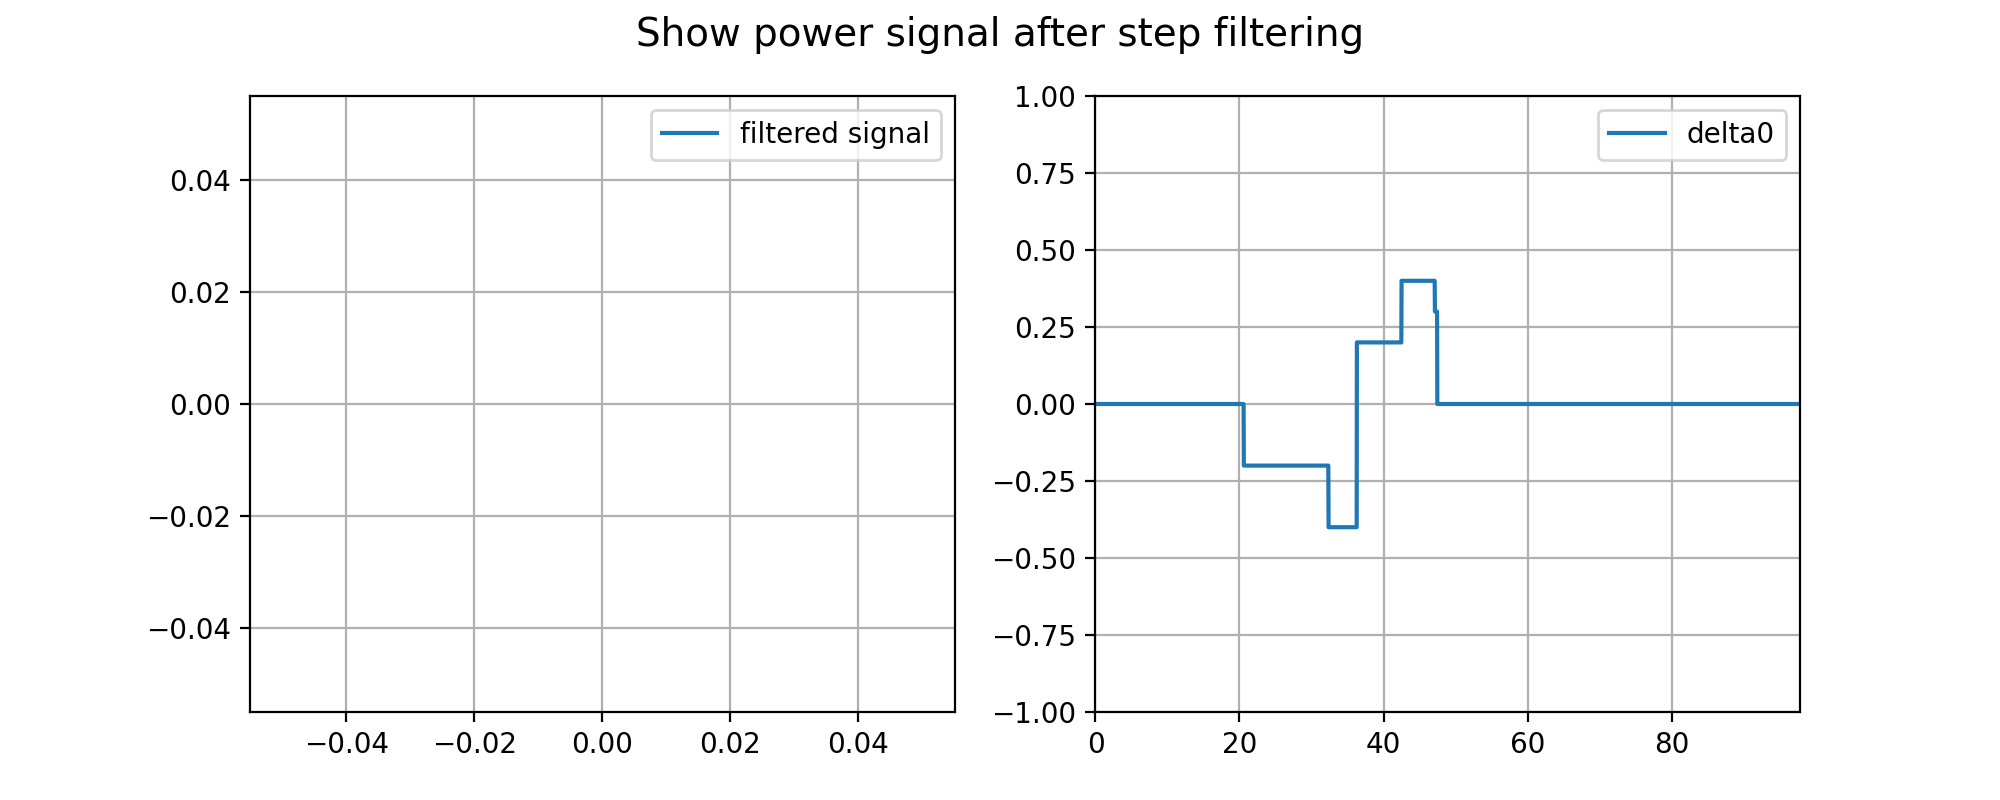

In [85]:
fig15, ax15 = plt.subplots(1,2,figsize=(10,4))
fig15.suptitle('Show power signal after step filtering', fontsize=14)

a=30
b=100

#ax15[0].plot(fd['t'], fd['pVehicle'], label='raw signal')
ax15[0].plot(fd['t'].iloc[a*30:-b*30], fd['u'].iloc[a*30:-b*30], label='filtered signal')

ax15[1].plot(fd['t'], fd['delta0'], label='delta0')
#ax15[1].plot(fd_hover['t'], fd_hover['delta0'], label='delta0 hover')

# add red boundary lines to highlight separation between take-off/landing and hovering
#ax15[1].plot([hoverStart, hoverStart],[-1, 1], 'r--')
#ax15[1].plot([hoverEnd, hoverEnd],[-1, 1], 'r--')


ax15[1].set_xlim(0, max(fd['t']))
ax15[1].set_xlim(0, max(fd['t']))

ax15[1].set_ylim(min(fd['t']), max(fd['t']))
ax15[1].set_ylim(-1,1)

for i in range(2):
    ax15[i].grid()
    ax15[i].legend()
#fd_hover = save

### Filter out forward flight

In [86]:
fdForward = fdForward[fdForward['u']>4]

### Calculate mean and median values for each $\Delta_0$

In [87]:
delta0Mean = pd.pivot_table(fdForward, index='delta0', aggfunc=np.mean)
delta0Median = pd.pivot_table(fdForward, index='delta0', aggfunc=np.median)

## Start of analysis

<IPython.core.display.Javascript object>


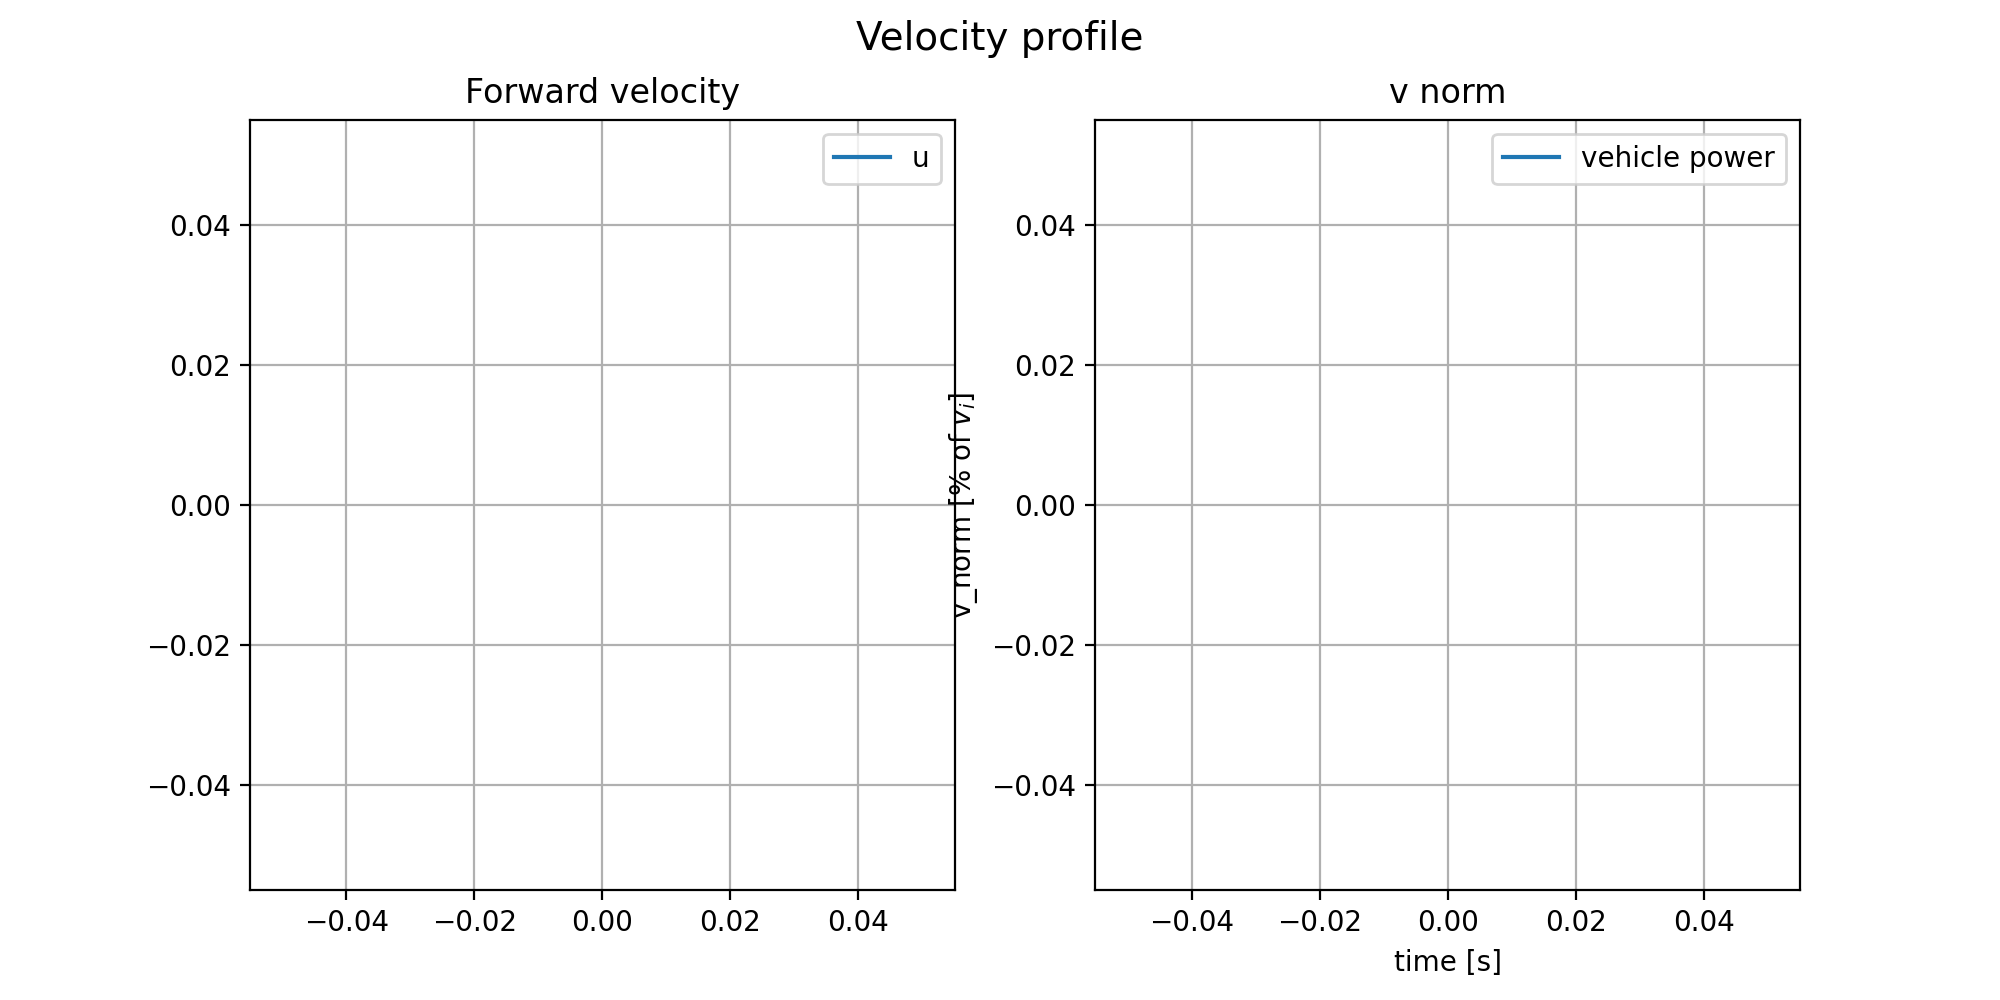

In [88]:
# plot histogram of vnorm with corresponding limit

fig0, ax0 = plt.subplots(1, 2, figsize=(10,5))
fig0.suptitle('Velocity profile', fontsize=14)

a=145
b=380

# vnorm in percentage of v_i
v_norm = np.sqrt(fd['u']**2 + fd['v']**2 + fd['w']**2)
v_norm_percentage = (v_norm/v_induced)*100  

# plot moving average of vertical velocity w and highlight the hovering sequence
ax0[0].plot(fdUnfiltered['t'].iloc[a*30:-b*30], fdUnfiltered['u'].iloc[a*30:-b*30], label='u', zorder=-1)
#ax0[0].scatter(fdForward['t'], fdForward['v'], color='r', s=5, label='v')
#ax0[0].plot(fdForward['t'], fdForward['u'], label='u')
#ax0[0].scatter(fdUnfiltered['t'].iloc[filteredMin], fdUnfiltered['u'].iloc[filteredMin],
#               marker='x', color='r', label='du')
#ax0[0].scatter(fdUnfiltered['t'].iloc[filteredMax], fdUnfiltered['u'].iloc[filteredMax],
#               marker='x', color='b', label='du')
#ax0[0].scatter(fd_hover['t'].iloc[localMax], fd_hover['u'].iloc[localMax], color='r', label='du')
#ax0[0].plot(fd['t'].iloc[hoverIndex], fd['w'].iloc[hoverIndex], label='w hover sequence')

# plot v_norm and hightlight hover sequence
#ax0[1].plot(fd_hover['t'], fd_hover['du'], label='du')
ax0[1].plot(fdUnfiltered['t'].iloc[a*30:-b*30], fdUnfiltered['pVehicle'].iloc[a*30:-b*30], label='vehicle power', zorder=-1)
#ax0[1].plot(fd['t'], fd['du'], label='du')
#ax0[1].scatter(fdUnfiltered['t'].iloc[filteredMin[0:6]],
#               fdUnfiltered['du'].iloc[filteredMin[0:6]], color='g', label='du')
#ax0[1].scatter(fdUnfiltered['t'].iloc[filteredMax[0:6]],
#               fdUnfiltered['du'].iloc[filteredMax[0:6]], color='r', label='du')
#ax0[1].plot(fd_hover['t'], fd_hover['I1'], label='du')
#ax0[1].scatter(fd_hoverRaw['t'].iloc[localMax], fd_hoverRaw['duMean'].iloc[localMax], color='r', label='du')

# add red boundary lines to highlight separation between take-off/landing and hovering
#ax0[1].plot([hoverStart, hoverStart],[0, 3], 'r--')
#ax0[1].plot([hoverEnd, hoverEnd],[0, 3], 'r--')

# add grid, legend, labels, etc.
ax0[0].grid()
ax0[0].legend()
ax0[0].set_title('Forward velocity')
#ax0[0].set_xlim(min(fd['t']), max(fd['t']))

ax0[1].set_title('v norm')
ax0[1].set_xlabel('time [s]')
ax0[1].set_ylabel('v_norm [% of $v_i$]')
ax0[1].grid()
ax0[1].legend()
#ax0[1].set_xlim(min(fd['t']),max(fd['t']))

<IPython.core.display.Javascript object>


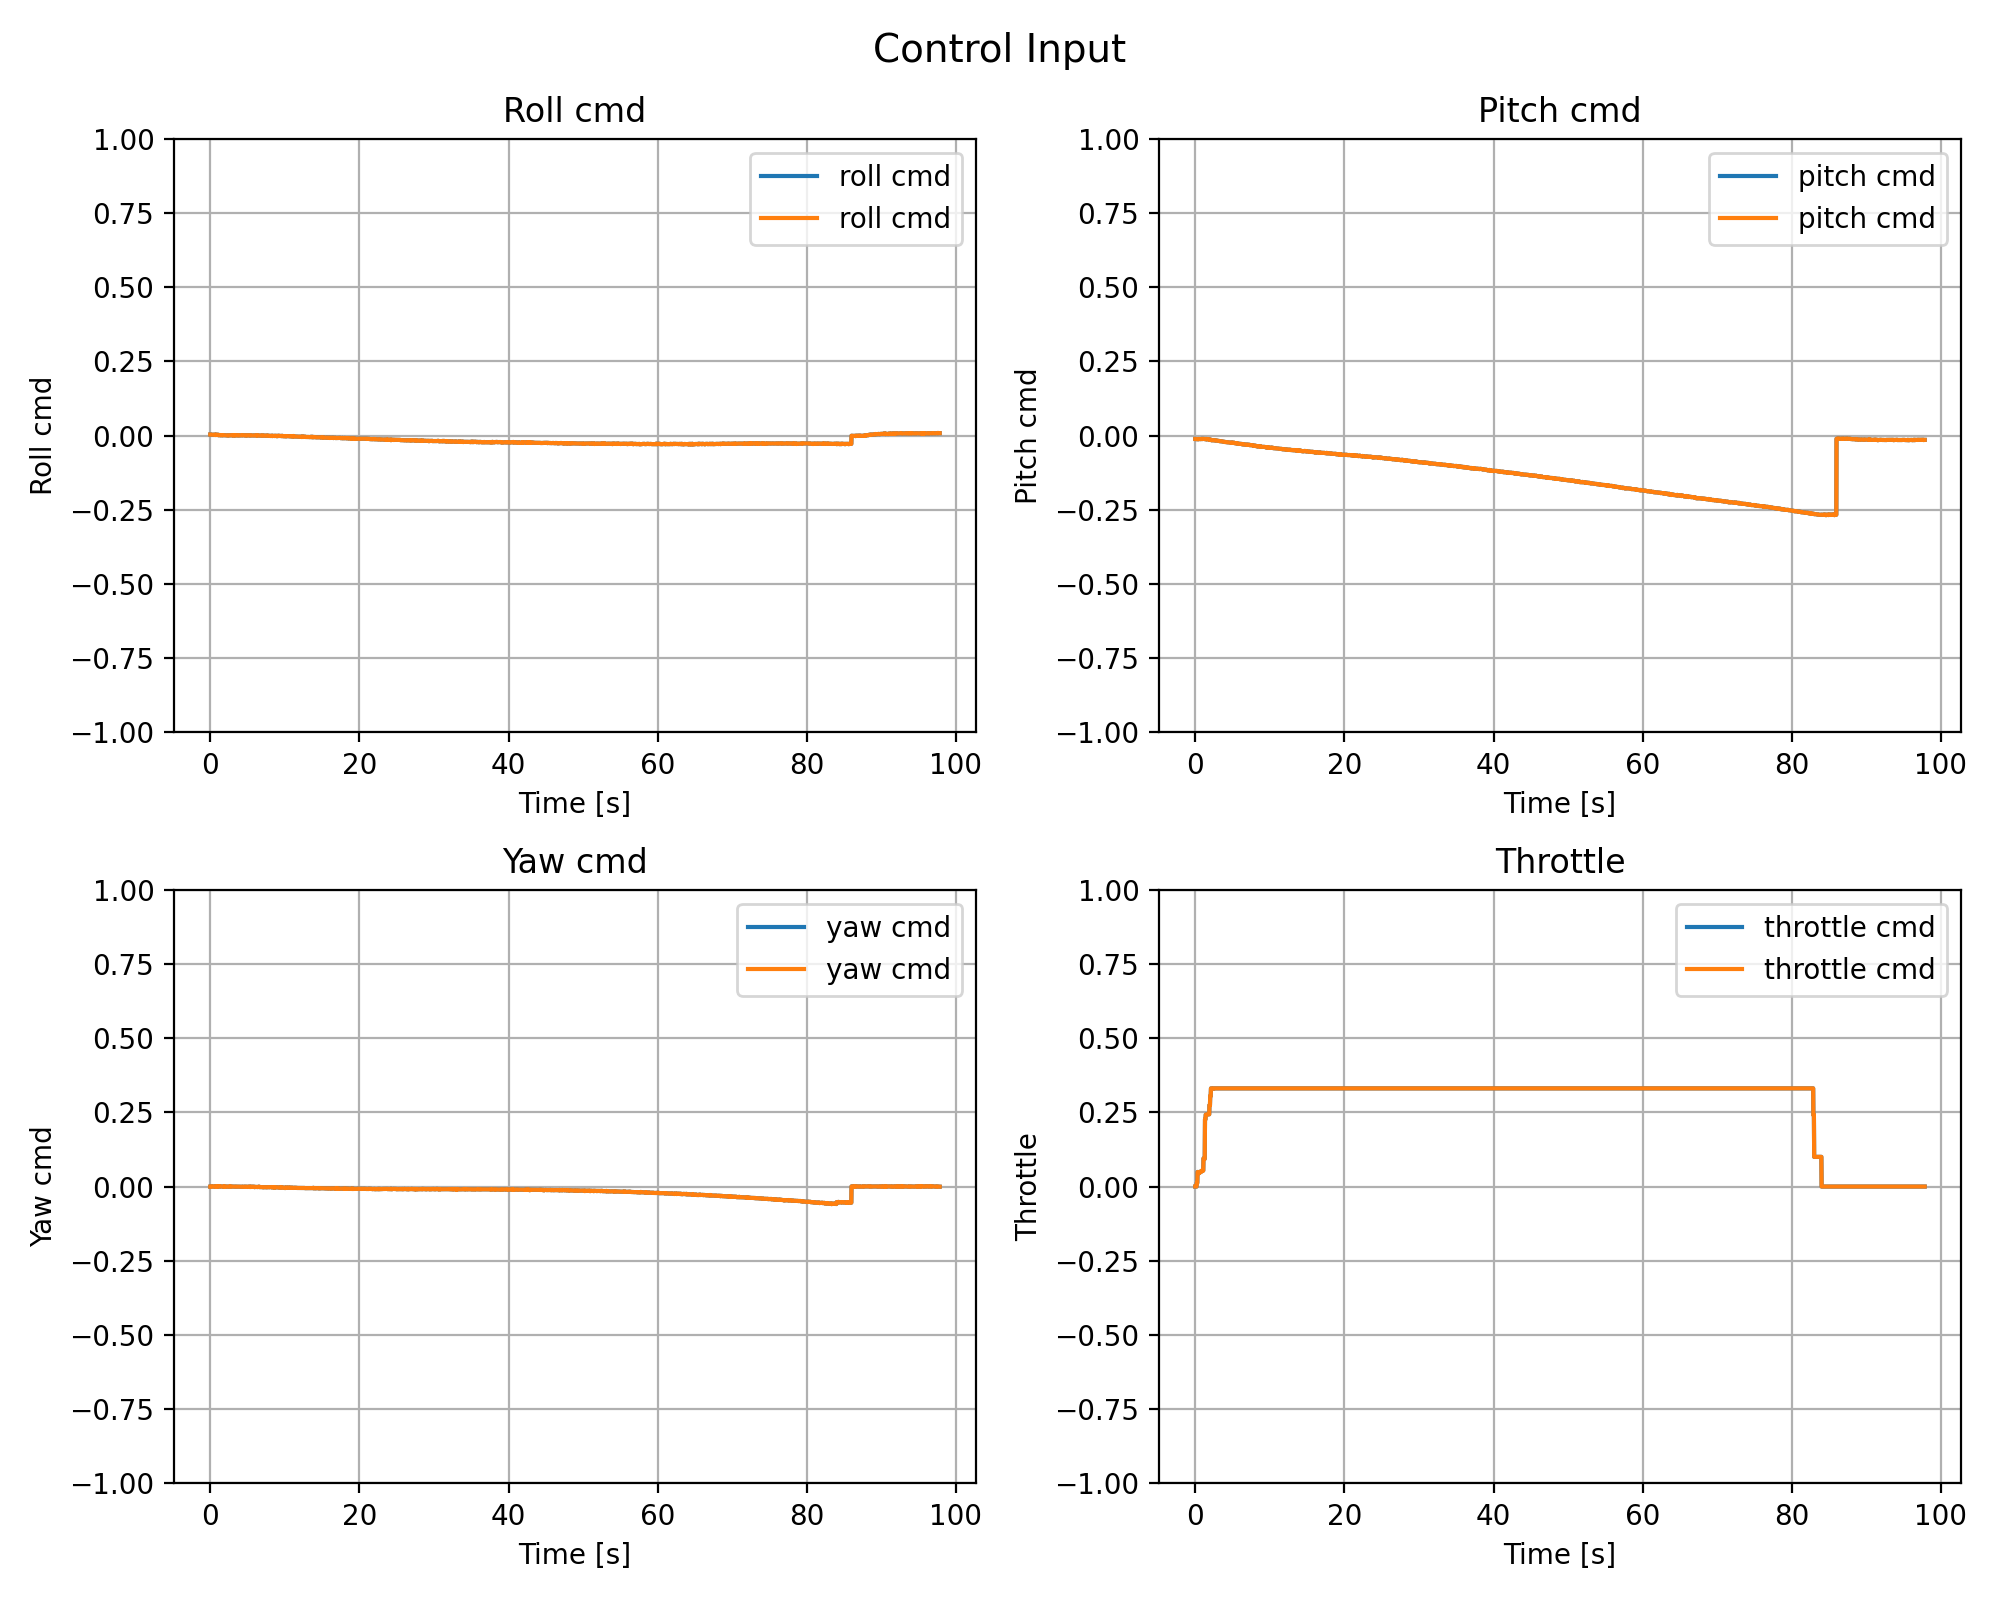

In [89]:
# Plot fd['uIn'] input

fig1, ax1 = plt.subplots(2, 2, figsize=(10,8))
fig1.suptitle('Control Input', fontsize=14)


ax1[0][0].plot(fdUnfiltered['t'], fdUnfiltered['uIn1'], label='roll cmd')
ax1[0][0].plot(fd['t'], fd['uIn1'], label='roll cmd')

ax1[0][1].plot(fdUnfiltered['t'], fdUnfiltered['uIn2'], label='pitch cmd')
ax1[0][1].plot(fd['t'], fd['uIn2'], label='pitch cmd')

ax1[1][0].plot(fdUnfiltered['t'], fdUnfiltered['uIn3'], label='yaw cmd')
ax1[1][0].plot(fd['t'], fd['uIn3'], label='yaw cmd')

ax1[1][1].plot(fd['t'], fd['uIn4'], label='throttle cmd')
ax1[1][1].plot(fd['t'], fd['uIn4'], label='throttle cmd')

for i in range(2):
    for j in range(2):
        ax1[i][j].set_xlabel('Time [s]')
        ax1[i][j].set_ylim(-1,1)
        ax1[i][j].grid()
        ax1[i][j].legend()

ax1[0][0].set_ylabel(f'Roll cmd')
ax1[0][1].set_ylabel(f'Pitch cmd')
ax1[1][0].set_ylabel(f'Yaw cmd')
ax1[1][1].set_ylabel(f'Throttle')

ax1[0][0].set_title(f'Roll cmd')
ax1[0][1].set_title(f'Pitch cmd')
ax1[1][0].set_title(f'Yaw cmd')
ax1[1][1].set_title(f'Throttle')

fig1.tight_layout()

<IPython.core.display.Javascript object>


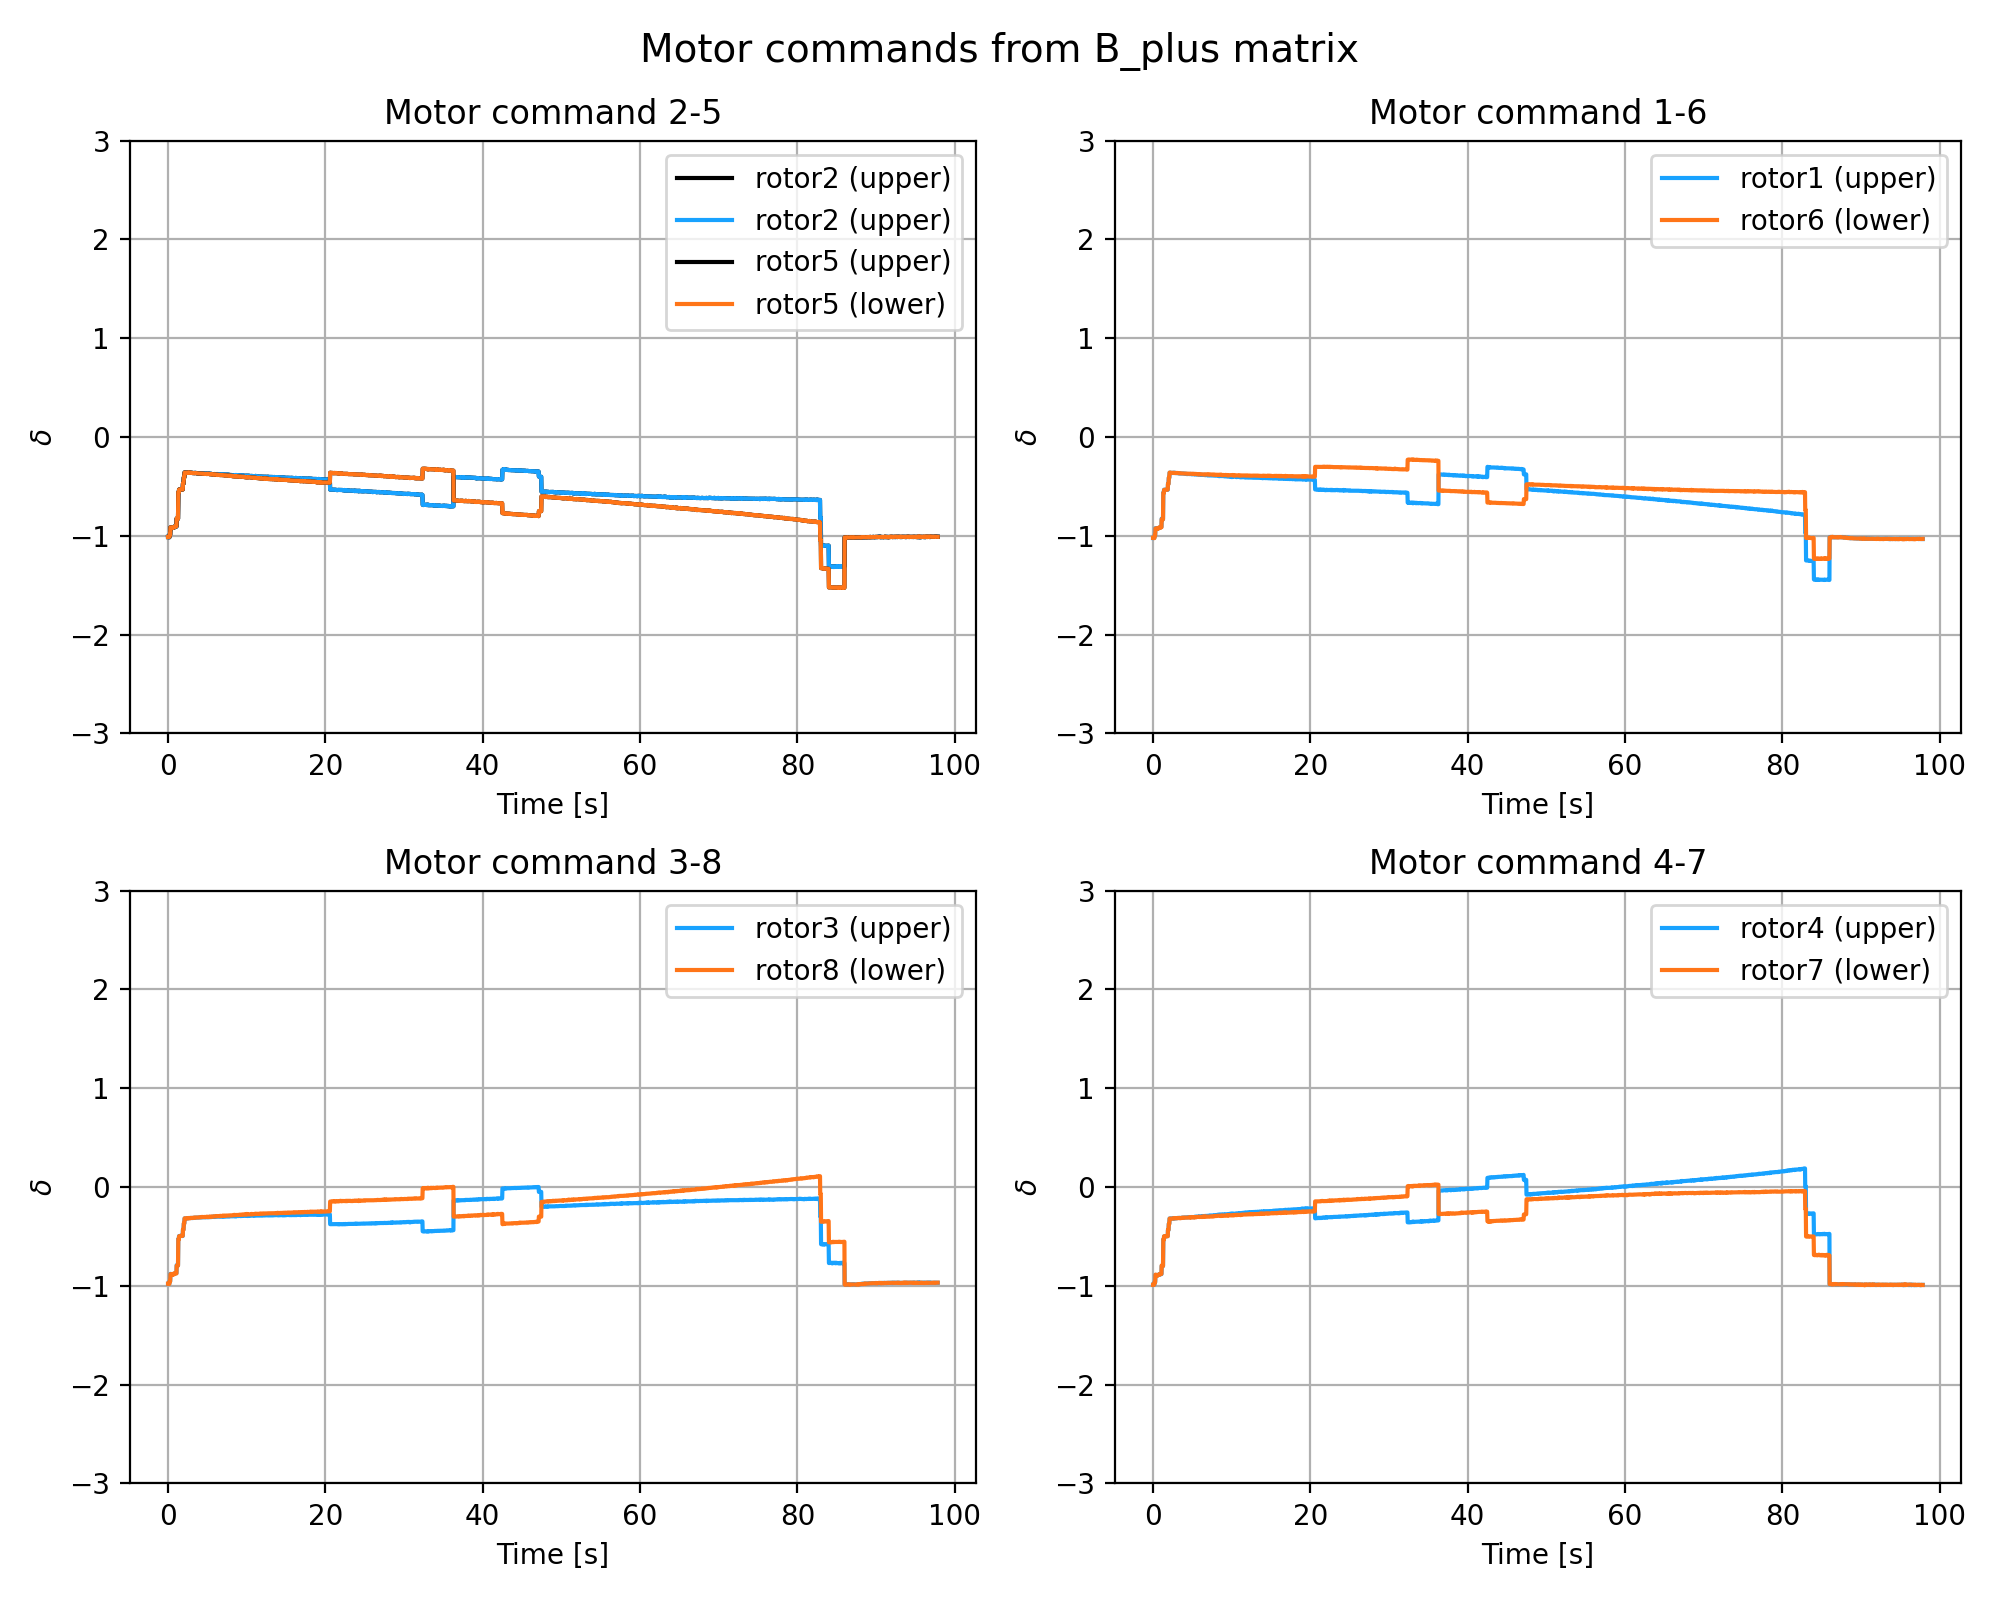

In [90]:
# Plot motor cmds

fig2, ax2 = plt.subplots(2, 2, figsize=(10,8))
fig2.suptitle('Motor commands from B_plus matrix', fontsize=14)

# Rotor pairs

ax2[0][0].plot(fdUnfiltered['t'], fdUnfiltered[f'uOut2'], color='k', label='rotor2 (upper)')
ax2[0][0].plot(fd['t'], fd[f'uOut2'], color=upCol, label='rotor2 (upper)')

ax2[0][0].plot(fdUnfiltered['t'], fdUnfiltered[f'uOut5'], color='k', label='rotor5 (upper)')
ax2[0][0].plot(fd['t'], fd[f'uOut5'], color=lowCol, label='rotor5 (lower)')

ax2[0][1].plot(fd['t'], fd[f'uOut1'], color=upCol, label='rotor1 (upper)')
ax2[0][1].plot(fd['t'], fd[f'uOut6'], color=lowCol, label='rotor6 (lower)')


ax2[1][0].plot(fd['t'], fd[f'uOut3'], color=upCol, label='rotor3 (upper)')
ax2[1][0].plot(fd['t'], fd[f'uOut8'], color=lowCol, label='rotor8 (lower)')

ax2[1][1].plot(fd['t'], fd[f'uOut4'], color=upCol, label='rotor4 (upper)')
ax2[1][1].plot(fd['t'], fd[f'uOut7'], color=lowCol, label='rotor7 (lower)')


for i in range(2):
    for j in range(2):
        ax2[i][j].set_xlabel('Time [s]')
        ax2[i][j].set_ylabel('$\delta$')
        ax2[i][j].set_ylim(-3,3)
        ax2[i][j].grid()
        ax2[i][j].legend()

ax2[0][0].set_title(f'Motor command 2-5')
ax2[0][1].set_title(f'Motor command 1-6')
ax2[1][0].set_title(f'Motor command 3-8')
ax2[1][1].set_title(f'Motor command 4-7')

fig2.tight_layout()

<IPython.core.display.Javascript object>


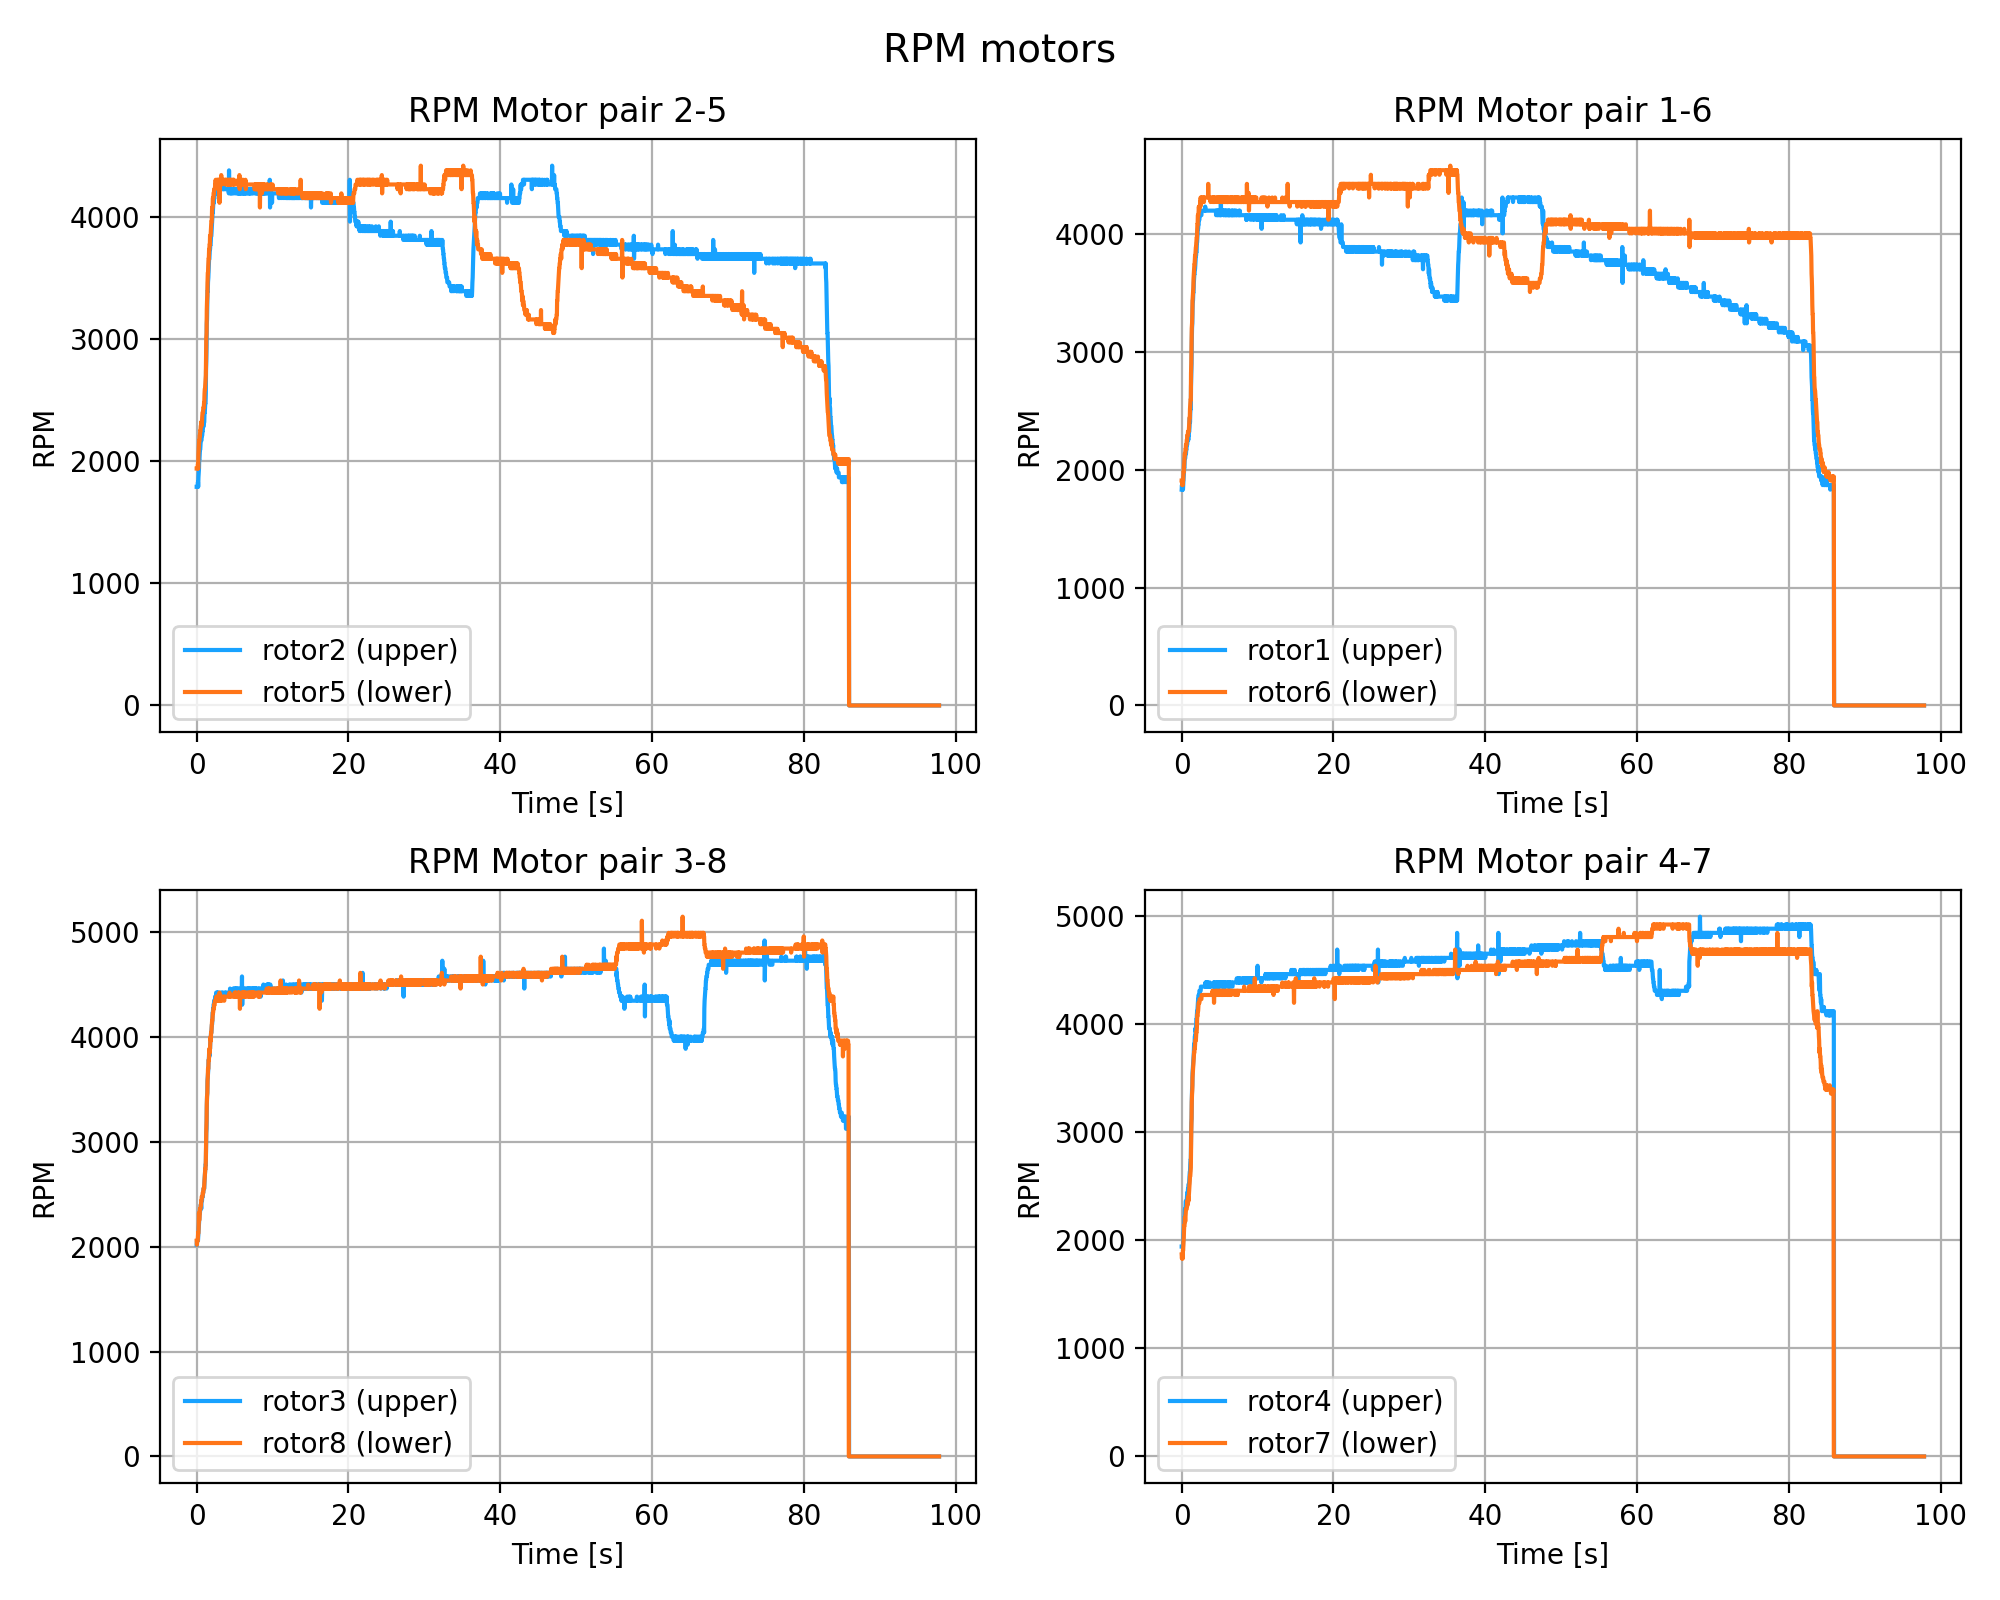

In [91]:
# Plot RPM over time

fig3, ax3 = plt.subplots(2, 2, figsize=(10,8))
fig3.suptitle('RPM motors', fontsize=14)

# Rotor pairs

ax3[0][0].plot(fd['t'], fd[f'rpm2'], color=upCol, label='rotor2 (upper)')
ax3[0][0].plot(fd['t'], fd[f'rpm5'], color=lowCol,label='rotor5 (lower)')

ax3[0][1].plot(fd['t'], fd[f'rpm1'], color=upCol, label='rotor1 (upper)')
ax3[0][1].plot(fd['t'], fd[f'rpm6'], color=lowCol, label='rotor6 (lower)')


ax3[1][0].plot(fd['t'], fd[f'rpm3'], color=upCol, label='rotor3 (upper)')
ax3[1][0].plot(fd['t'], fd[f'rpm8'], color=lowCol, label='rotor8 (lower)')

ax3[1][1].plot(fd['t'], fd[f'rpm4'], color=upCol, label='rotor4 (upper)')
ax3[1][1].plot(fd['t'], fd[f'rpm7'], color=lowCol, label='rotor7 (lower)')


for i in range(2):
    for j in range(2):
        ax3[i][j].set_xlabel('Time [s]')
        ax3[i][j].set_ylabel('RPM')
        ax3[i][j].grid()
        ax3[i][j].legend()

ax3[0][0].set_title(f'RPM Motor pair 2-5')
ax3[0][1].set_title(f'RPM Motor pair 1-6')
ax3[1][0].set_title(f'RPM Motor pair 3-8')
ax3[1][1].set_title(f'RPM Motor pair 4-7')

fig3.tight_layout()

<IPython.core.display.Javascript object>


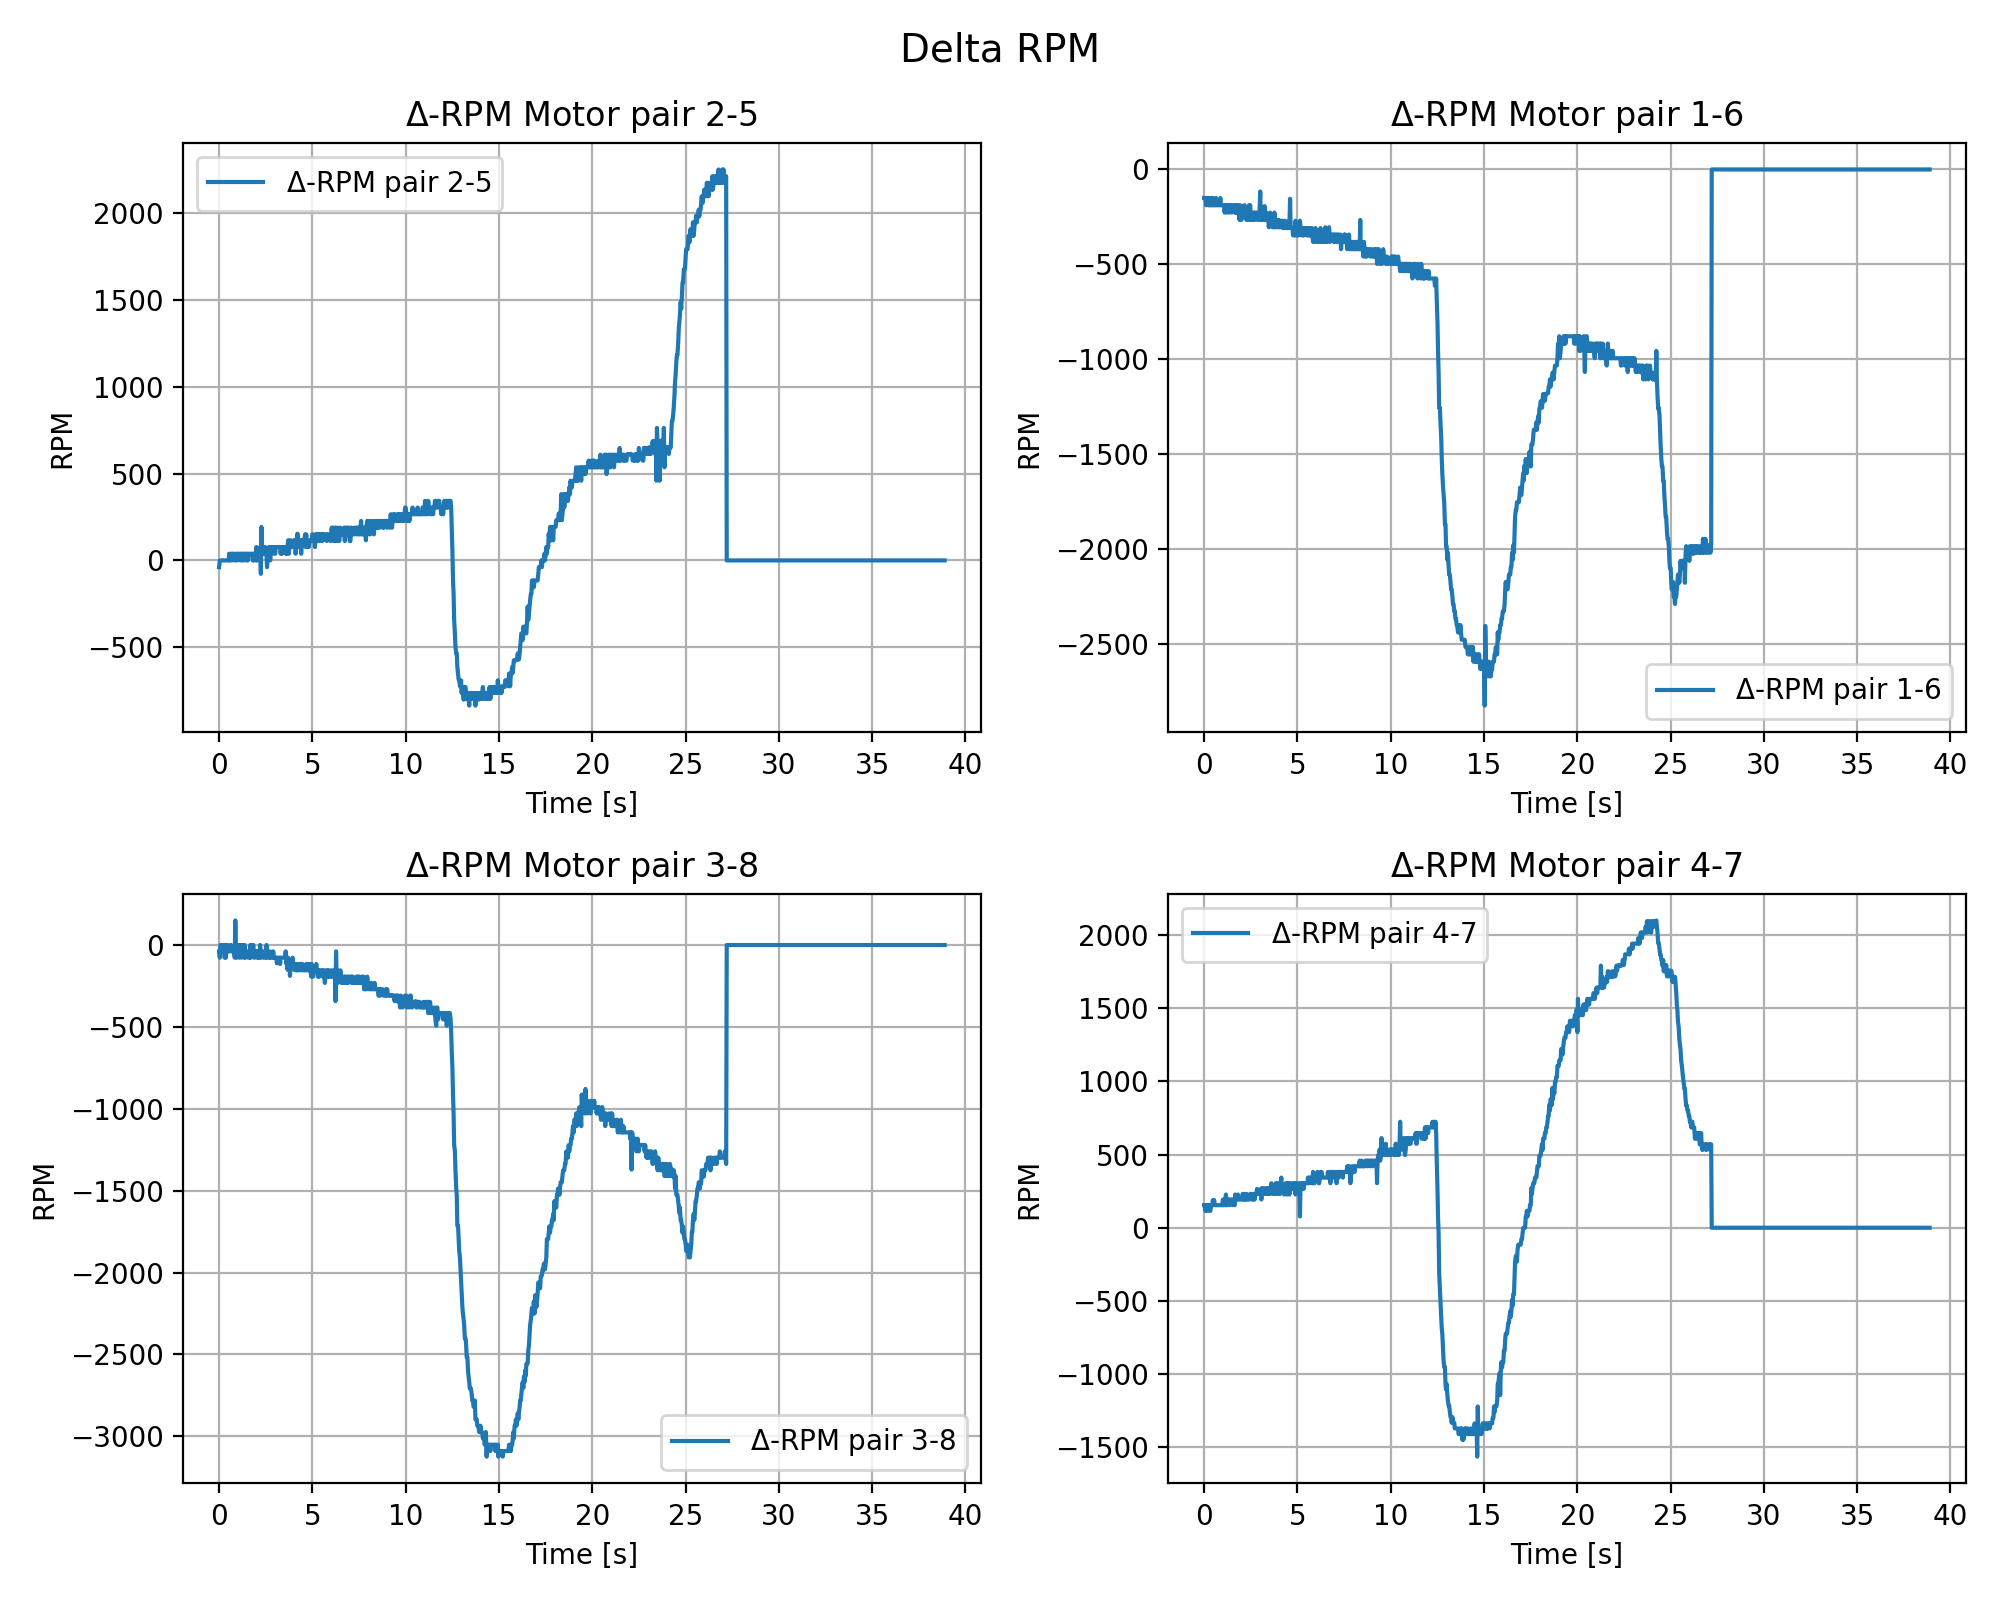

In [39]:
# delta RPM

fig4, ax4 = plt.subplots(2, 2, figsize=(10,8))
fig4.suptitle('Delta RPM', fontsize=14)

# Rotor pairs

ax4[0][0].plot(fd['t'], fd['dRpmArm1'], label='$\Delta$-RPM pair 2-5')
ax4[0][1].plot(fd['t'], fd['dRpmArm2'], label='$\Delta$-RPM pair 1-6')
ax4[1][0].plot(fd['t'], fd['dRpmArm3'], label='$\Delta$-RPM pair 3-8')
ax4[1][1].plot(fd['t'], fd['dRpmArm4'], label='$\Delta$-RPM pair 4-7')

for i in range(2):
    for j in range(2):
        ax4[i][j].set_xlabel('Time [s]')
        ax4[i][j].set_ylabel('RPM')
        ax4[i][j].grid()
        ax4[i][j].legend()

ax4[0][0].set_title(f'$\Delta$-RPM Motor pair 2-5')
ax4[0][1].set_title(f'$\Delta$-RPM Motor pair 1-6')
ax4[1][0].set_title(f'$\Delta$-RPM Motor pair 3-8')
ax4[1][1].set_title(f'$\Delta$-RPM Motor pair 4-7')

fig4.tight_layout()

<IPython.core.display.Javascript object>


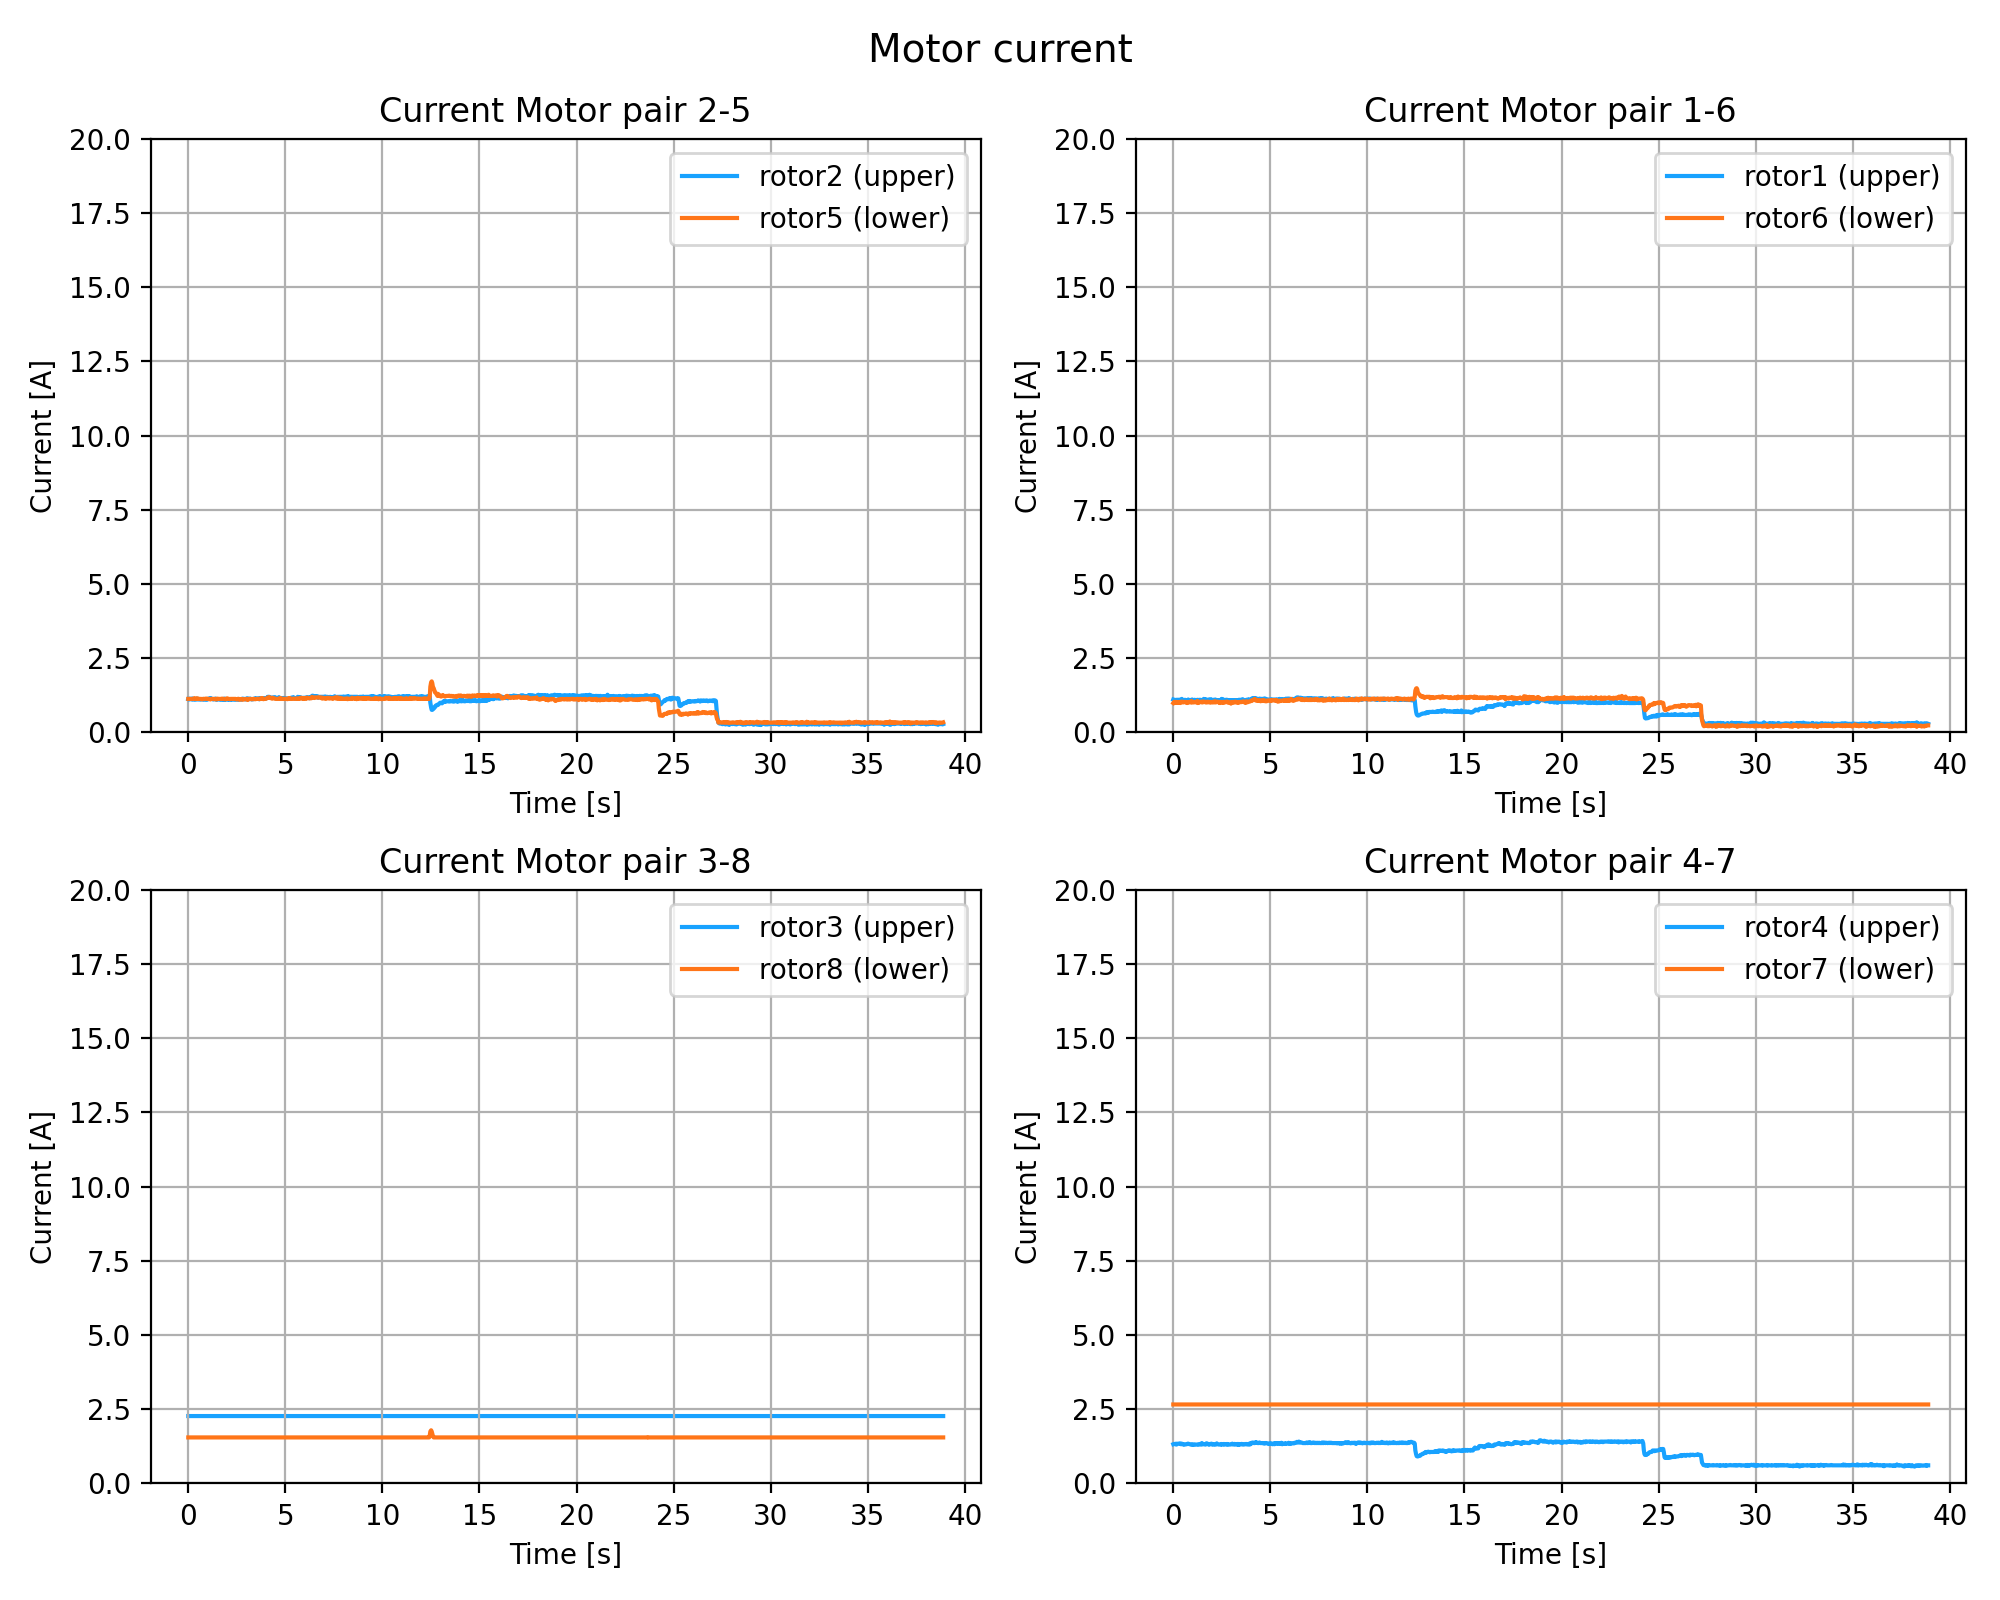

In [40]:
# Plot current over time

fig5, ax5 = plt.subplots(2, 2, figsize=(10,8))
fig5.suptitle('Motor current', fontsize=14)
# Rotor pairs

ax5[0][0].plot(fd['t'],fd['I2'], color=upCol, label='rotor2 (upper)')
ax5[0][0].plot(fd['t'],fd['I5'], color=lowCol, label='rotor5 (lower)')

ax5[0][1].plot(fd['t'],fd['I1'], color=upCol, label='rotor1 (upper)')
ax5[0][1].plot(fd['t'],fd['I6'], color=lowCol, label='rotor6 (lower)')


ax5[1][0].plot(fd['t'],fd['I3'], color=upCol, label='rotor3 (upper)', zorder=1)
ax5[1][0].plot(fd['t'],fd['I8'], color=lowCol, label='rotor8 (lower)')

ax5[1][1].plot(fd['t'],fd['I4'], color=upCol, label='rotor4 (upper)')
ax5[1][1].plot(fd['t'],fd['I7'], color=lowCol, label='rotor7 (lower)')

for i in range(2):
    for j in range(2):
        ax5[i][j].set_xlabel('Time [s]')
        ax5[i][j].set_ylabel('Current [A]')
        ax5[i][j].set_ylim(0,20)
        ax5[i][j].grid()
        ax5[i][j].legend()

ax5[0][0].set_title(f'Current Motor pair 2-5')
ax5[0][1].set_title(f'Current Motor pair 1-6')
ax5[1][0].set_title(f'Current Motor pair 3-8')
ax5[1][1].set_title(f'Current Motor pair 4-7')

fig5.tight_layout()

<IPython.core.display.Javascript object>


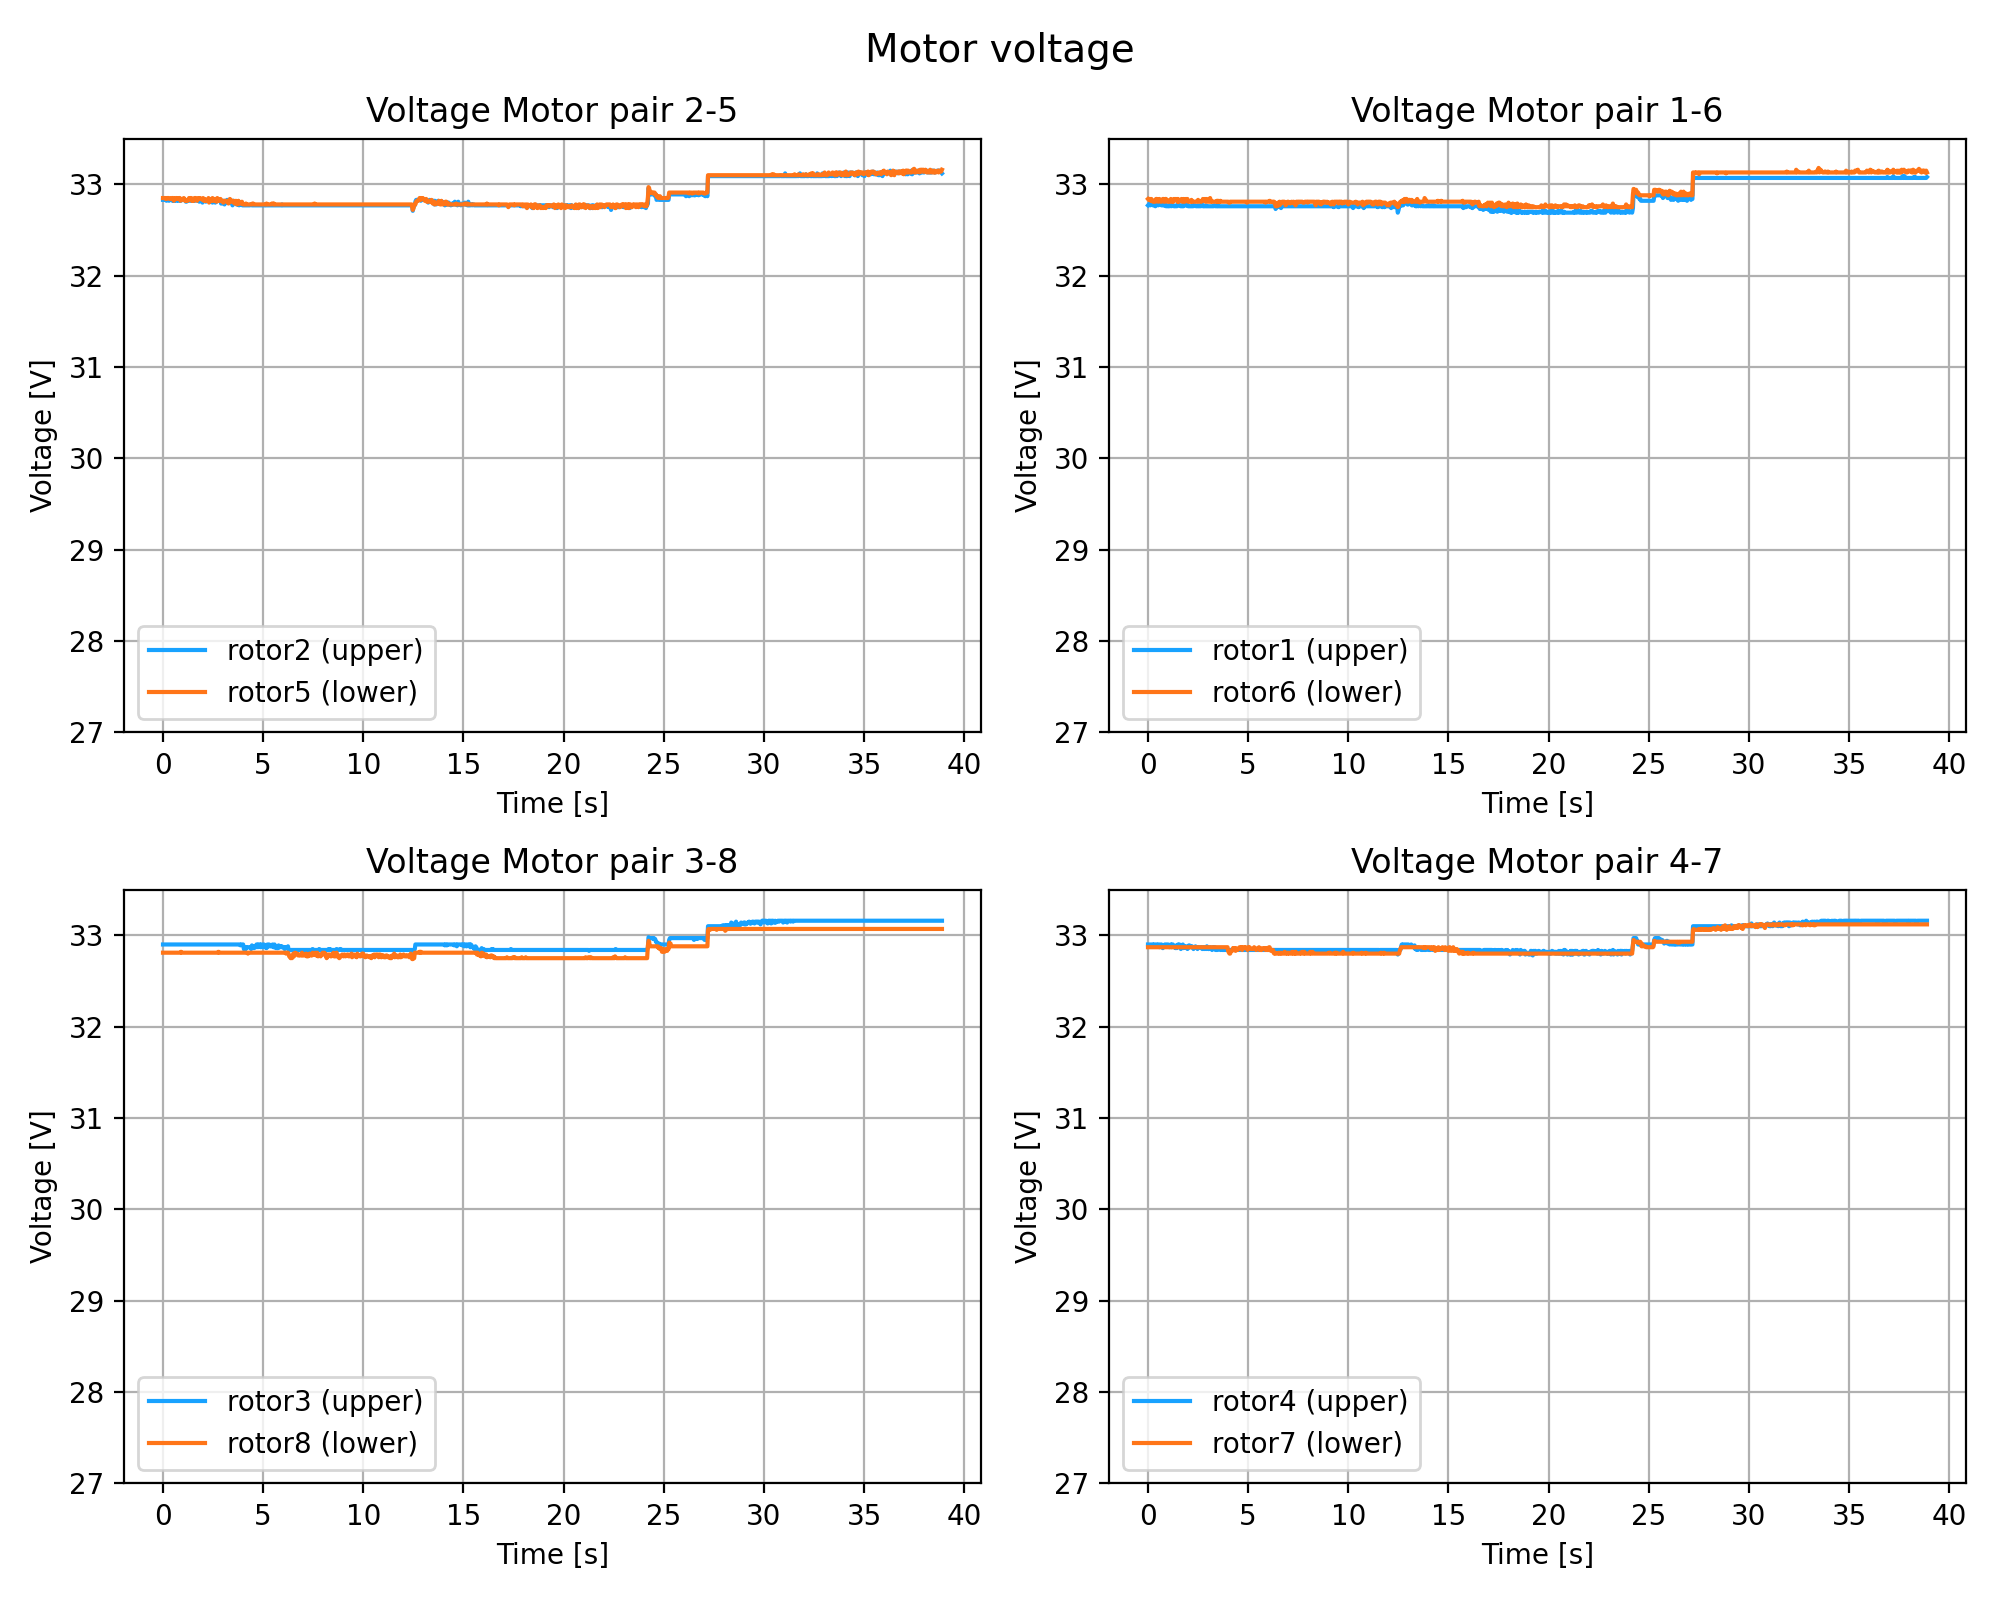

In [41]:
# voltage over time

fig6, ax6 = plt.subplots(2, 2, figsize=(10,8))
fig6.suptitle('Motor voltage', fontsize=14)
# Rotor pairs

ax6[0][0].plot(fd['t'], fd['U2'], color=upCol, label='rotor2 (upper)')
ax6[0][0].plot(fd['t'], fd['U5'], color=lowCol, label='rotor5 (lower)')

ax6[0][1].plot(fd['t'], fd['U1'], color=upCol, label='rotor1 (upper)')
ax6[0][1].plot(fd['t'], fd['U6'], color=lowCol, label='rotor6 (lower)')


ax6[1][0].plot(fd['t'], fd['U3'], color=upCol, label='rotor3 (upper)')
ax6[1][0].plot(fd['t'], fd['U8'], color=lowCol, label='rotor8 (lower)')

ax6[1][1].plot(fd['t'], fd['U4'], color=upCol, label='rotor4 (upper)')
ax6[1][1].plot(fd['t'], fd['U7'], color=lowCol, label='rotor7 (lower)')


for i in range(2):
    for j in range(2):
        ax6[i][j].set_xlabel('Time [s]')
        ax6[i][j].set_ylabel('Voltage [V]')
        ax6[i][j].set_ylim(27, 33.5)
        ax6[i][j].grid()
        ax6[i][j].legend()

ax6[0][0].set_title(f'Voltage Motor pair 2-5')
ax6[0][1].set_title(f'Voltage Motor pair 1-6')
ax6[1][0].set_title(f'Voltage Motor pair 3-8')
ax6[1][1].set_title(f'Voltage Motor pair 4-7')

fig6.tight_layout()

# Power analysis

<IPython.core.display.Javascript object>


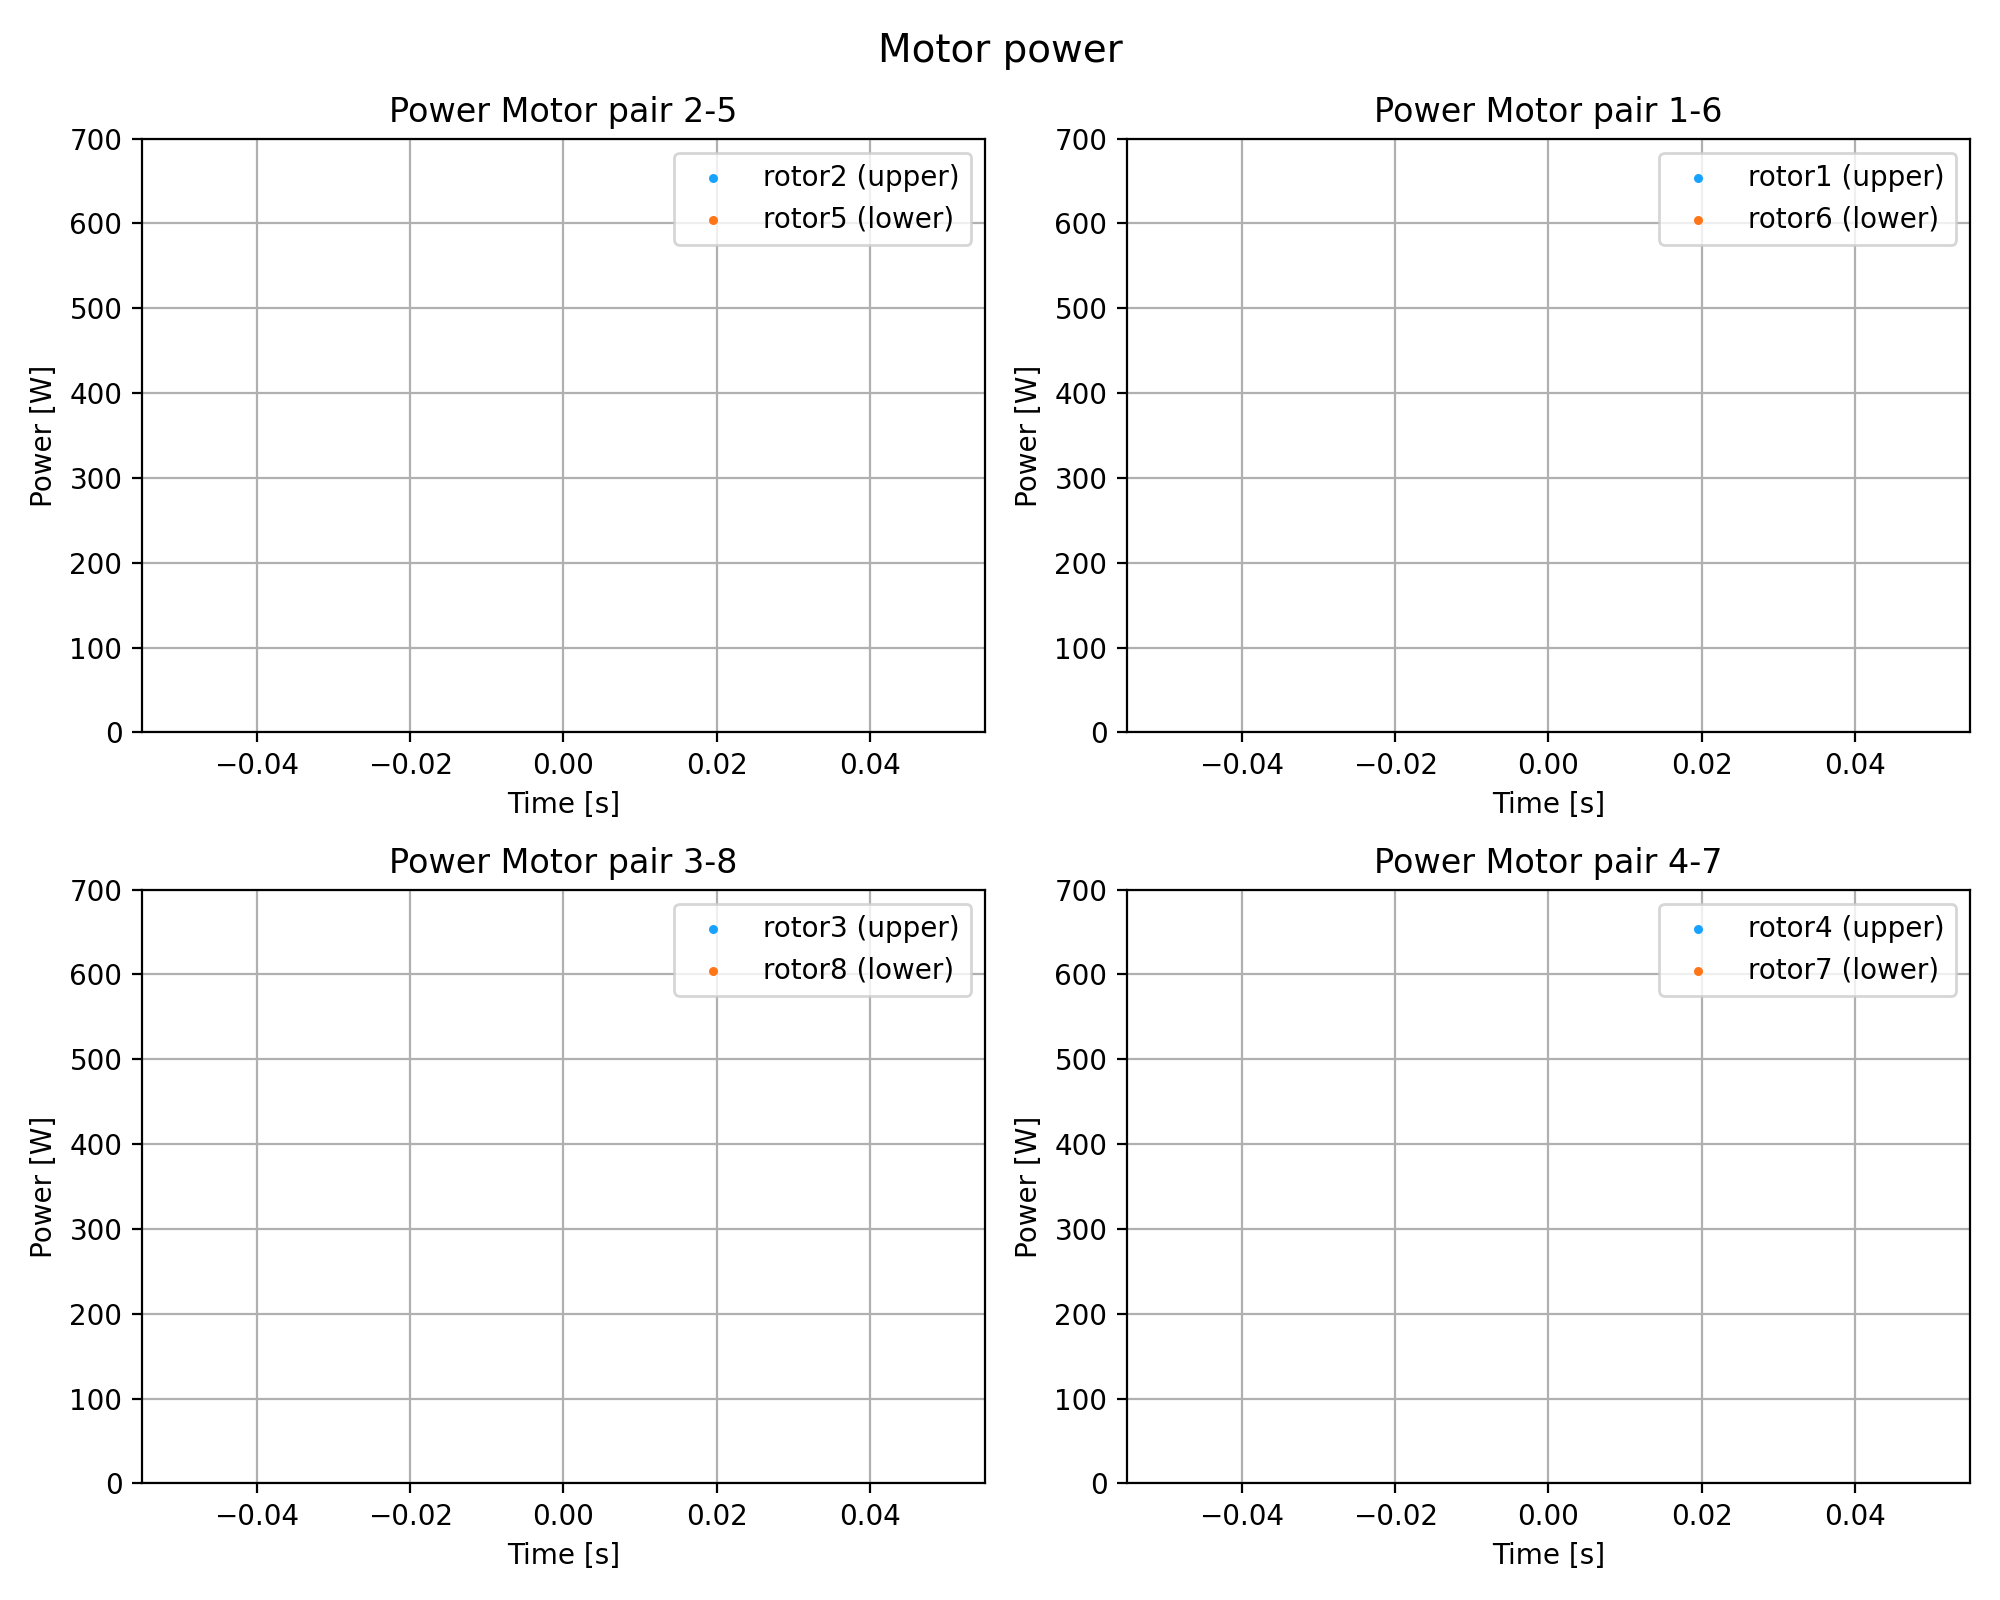

In [42]:
# Power over time for each motor

fig7, ax7 = plt.subplots(2, 2, figsize=(10,8))
fig7.suptitle('Motor power', fontsize=14)

# Rotor pairs

ax7[0][0].scatter(fdForward['t'], fdForward['pMo2'], s=5, color=upCol, label='rotor2 (upper)')
ax7[0][0].scatter(fdForward['t'], fdForward['pMo5'], s=5, color=lowCol, label='rotor5 (lower)')

ax7[0][1].scatter(fdForward['t'], fdForward['pMo1'], s=5, color=upCol, label='rotor1 (upper)')
ax7[0][1].scatter(fdForward['t'], fdForward['pMo6'], s=5, color=lowCol, label='rotor6 (lower)')


ax7[1][0].scatter(fdForward['t'], fdForward['pMo3'], s=5, color=upCol, label='rotor3 (upper)')
ax7[1][0].scatter(fdForward['t'], fdForward['pMo8'], s=5, color=lowCol, label='rotor8 (lower)')

ax7[1][1].scatter(fdForward['t'], fdForward['pMo4'], s=5, color=upCol, label='rotor4 (upper)')
ax7[1][1].scatter(fdForward['t'], fdForward['pMo7'], s=5, color=lowCol, label='rotor7 (lower)')


for i in range(2):
    for j in range(2):
        ax7[i][j].set_xlabel('Time [s]')
        ax7[i][j].set_ylabel('Power [W]')
        ax7[i][j].set_ylim(0,700)
        ax7[i][j].grid()
        ax7[i][j].legend()

ax7[0][0].set_title(f'Power Motor pair 2-5')
ax7[0][1].set_title(f'Power Motor pair 1-6')
ax7[1][0].set_title(f'Power Motor pair 3-8')
ax7[1][1].set_title(f'Power Motor pair 4-7')

fig7.tight_layout()

In [ ]:
# Perform regression Power vs. RPM

rpm_range = np.linspace(0, 3000, 100).reshape(-1,1)
rpmRegMotorFiltered = []

for i in range(1,9):
    filtered = fd_hover[fd_hover[f'I{i}']> fd_hover[f'I{i}'].min()]
    filtered = filtered[filtered[f'rpm{i}']> 0]
    X = filtered[[f'rpm{i}']]
    Y = filtered[[f'pMo{i}']]
    features = PolynomialFeatures(degree=3, include_bias=False).fit_transform(X)
    rpmRegression = LinearRegression(fit_intercept=False, positive=True)
    rpmRegression.fit(features, Y)
    rpm_range_poly = PolynomialFeatures(degree=3, include_bias=False).fit_transform(rpm_range)
    reg_curve = rpmRegression.predict(rpm_range_poly)
    rpmRegMotorFiltered.append(reg_curve)

In [ ]:
# Power over effective RPM

fig8, ax8 = plt.subplots(2, 2, figsize=(10,8))
fig8.suptitle('Power vs. RPM', fontsize=14)

# Plot outliers
ax8[0][0].scatter(fdUnfiltered['rpm2'], fdUnfiltered['pMo2'], s=markersize, color='gray')
ax8[0][0].scatter(fdUnfiltered['rpm5'], fdUnfiltered['pMo5'], s=markersize, color='gray', label='outliers')
ax8[0][1].scatter(fdUnfiltered['rpm1'], fdUnfiltered['pMo1'], s=markersize, color='gray')
ax8[0][1].scatter(fdUnfiltered['rpm6'], fdUnfiltered['pMo6'], s=markersize, color='gray', label='outliers')
ax8[1][0].scatter(fdUnfiltered['rpm3'], fdUnfiltered['pMo3'], s=markersize, color='gray')
ax8[1][0].scatter(fdUnfiltered['rpm8'], fdUnfiltered['pMo8'], s=markersize, color='gray', label='outliers')
ax8[1][1].scatter(fdUnfiltered['rpm4'], fdUnfiltered['pMo4'], s=markersize, color='gray')
ax8[1][1].scatter(fdUnfiltered['rpm7'], fdUnfiltered['pMo7'], s=markersize, color='gray', label='outliers')


ax8[0][0].scatter(fdForward['rpm2'], fdForward['pMo2'], s=markersize, color=upCol, label='rotor2 (upper)')
ax8[0][0].scatter(fdForward['rpm5'], fdForward['pMo5'], s=markersize, color=lowCol, label='rotor5 (lower)')

ax8[0][1].scatter(fdForward['rpm1'], fdForward['pMo1'], s=markersize, color=upCol, label='rotor1 (upper)')
ax8[0][1].scatter(fdForward['rpm6'], fdForward['pMo6'], s=markersize, color=lowCol, label='rotor6 (lower)')

ax8[1][0].scatter(fdForward['rpm3'], fdForward['pMo3'], s=markersize, color=upCol, label='rotor3 (upper)')
ax8[1][0].scatter(fdForward['rpm8'], fdForward['pMo8'], s=markersize, color=lowCol, label='rotor8 (lower)')

ax8[1][1].scatter(fdForward['rpm4'], fdForward['pMo4'], s=markersize, color=upCol, label='rotor4 (upper)')
ax8[1][1].scatter(fdForward['rpm7'], fdForward['pMo7'], s=markersize, color=lowCol, label='rotor7 (lower)')

ax8[0][0].plot(rpm_range, rpmRegMotorFiltered[1], linestyle='dashed', color=upMeanCol, label='rotor5 (regression)')
ax8[0][0].plot(rpm_range, rpmRegMotorFiltered[4], linestyle='dashed', color=lowMeanCol, label='rotor5 (regression)')

ax8[0][1].plot(rpm_range, rpmRegMotorFiltered[0], linestyle='dashed', color=upMeanCol, label='rotor1 (regression)')
ax8[0][1].plot(rpm_range, rpmRegMotorFiltered[5], linestyle='dashed', color=lowMeanCol, label='rotor6 (regression)')

ax8[1][0].plot(rpm_range, rpmRegMotorFiltered[2], linestyle='dashed', color=upMeanCol, label='rotor3 (regression)')
ax8[1][0].plot(rpm_range, rpmRegMotorFiltered[7], linestyle='dashed', color=lowMeanCol, label='rotor8 (regression)')

ax8[1][1].plot(rpm_range, rpmRegMotorFiltered[3], linestyle='dashed', color=upMeanCol, label='rotor4 (regression)')
ax8[1][1].plot(rpm_range, rpmRegMotorFiltered[6], linestyle='dashed', color=lowMeanCol, label='rotor7 (regression)')

for i in range(2):
    for j in range(2):
        ax8[i][j].set_xlabel('RPM')
        ax8[i][j].set_ylabel('Power [W]')
        ax8[i][j].set_xlim(0,4000)
        ax8[i][j].set_ylim(0,600)
        ax8[i][j].grid()
        ax8[i][j].legend()

ax8[0][0].set_title(f'Power vs. RPM motor-pair 2-5')
ax8[0][1].set_title(f'Power vs. RPM motor-pair 1-6')
ax8[1][0].set_title(f'Power vs. RPM motor-pair 3-8')
ax8[1][1].set_title(f'Power vs. RPM motor-pair 4-7')

fig8.tight_layout()

In [ ]:
# Power per motor over delta0

fig9, ax9 = plt.subplots(2, 2, figsize=(10,8))
fig9.suptitle('Power vs. $\Delta_{0}$ per motor', fontsize=14)

# Outliers
#ax9[0][0].scatter(fdUnfiltered['delta0'], fdUnfiltered['pMo2'], s=markersize, color= 'gray')
#ax9[0][0].scatter(fdUnfiltered['delta0'], fdUnfiltered['pMo5'], s=markersize, color= 'gray', label='outliers')
#ax9[0][1].scatter(fdUnfiltered['delta0'], fdUnfiltered['pMo1'], s=markersize, color= 'gray')
#ax9[0][1].scatter(fdUnfiltered['delta0'], fdUnfiltered['pMo6'], s=markersize, color= 'gray', label='outliers')
#ax9[1][0].scatter(fdUnfiltered['delta0'], fdUnfiltered['pMo3'], s=markersize, color= 'gray')
#ax9[1][0].scatter(fdUnfiltered['delta0'], fdUnfiltered['pMo8'], s=markersize, color= 'gray', label='outliers')
#ax9[1][1].scatter(fdUnfiltered['delta0'], fdUnfiltered['pMo4'], s=markersize, color= 'gray')
#ax9[1][1].scatter(fdUnfiltered['delta0'], fdUnfiltered['pMo7'], s=markersize, color= 'gray', label='outliers')

# Rotor pairs
ax9[0][0].scatter(fdForward['delta0'], fdForward['pMo2'], s=markersize, color= upCol, label='rotor2 (upper)')
ax9[0][0].scatter(delta0Mean.index, delta0Mean['pMo2'], marker='x', color=upMeanCol, s=50, label='rotor2 mean')

ax9[0][0].scatter(fdForward['delta0'], fdForward['pMo5'], s=markersize, color= lowCol, label='rotor5 (lower)')
ax9[0][0].scatter(delta0Mean.index, delta0Mean['pMo5'], marker='x', color=lowMeanCol, s=50, label='rotor5 mean')

ax9[0][1].scatter(fdForward['delta0'], fdForward['pMo1'], s=markersize, color= upCol, label='rotor1 (upper)')
ax9[0][1].scatter(delta0Mean.index, delta0Mean['pMo1'], marker='x', color=upMeanCol, s=50, label='rotor1 mean')

ax9[0][1].scatter(fdForward['delta0'], fdForward['pMo6'], s=markersize, color= lowCol, label='rotor6 (lower)')
ax9[0][1].scatter(delta0Mean.index, delta0Mean['pMo6'], marker='x', color=lowMeanCol, s=50, label='rotor6 mean')

ax9[1][0].scatter(fdForward['delta0'], fdForward['pMo3'], s=markersize, color= upCol, label='rotor3 (upper)')
ax9[1][0].scatter(delta0Mean.index, delta0Mean['pMo3'], marker='x', color=upMeanCol, s=50, label='rotor3 mean')

ax9[1][0].scatter(fdForward['delta0'], fdForward['pMo8'], s=markersize, color= lowCol, label='rotor8 (lower)')
ax9[1][0].scatter(delta0Mean.index, delta0Mean['pMo8'], marker='x', color=lowMeanCol, s=50, label='rotor8 mean')

ax9[1][1].scatter(fdForward['delta0'], fdForward['pMo4'], s=markersize, color= upCol, label='rotor4 (upper)')
ax9[1][1].scatter(delta0Mean.index, delta0Mean['pMo4'], marker='x', color=upMeanCol, s=50, label='rotor4 mean')

ax9[1][1].scatter(fdForward['delta0'], fdForward['pMo7'], s=markersize, color= lowCol, label='rotor7 (lower)')
ax9[1][1].scatter(delta0Mean.index, delta0Mean['pMo7'], marker='x', color=lowMeanCol, s=50, label='rotor7 mean')

#
for i in range(2):
    for j in range(2):
        ax9[i][j].set_xlabel('$\Delta_{0}$')
        ax9[i][j].set_ylabel('Power [W]')
        ax9[i][j].set_ylim(0,600)
        ax9[i][j].grid()
        ax9[i][j].legend()

ax9[0][0].set_title(f'Motor pair 2-5: Power vs. $\Delta_0$')
ax9[0][1].set_title(f'Motor pair 1-6: Power vs. $\Delta_0$')
ax9[1][0].set_title(f'Motor pair 3-8: Power vs. $\Delta_0$')
ax9[1][1].set_title(f'Motor pair 4-7: Power vs. $\Delta_0$')

fig9.tight_layout()

In [ ]:
# Power per arm over delta0

fig10, ax10 = plt.subplots(2, 2, figsize=(10,8))
fig10.suptitle('Power vs. $\Delta_{0}$ per arm', fontsize=14)

# Arms
#ax10[0][0].scatter(fdUnfiltered['delta0'], fdUnfiltered['pArm1'], color='gray', s=markersize, label='outliers')
#ax10[0][1].scatter(fdUnfiltered['delta0'], fdUnfiltered['pArm2'], color='gray', s=markersize, label='outliers')
#ax10[1][0].scatter(fdUnfiltered['delta0'], fdUnfiltered['pArm3'], color='gray', s=markersize, label='outliers')
#ax10[1][1].scatter(fdUnfiltered['delta0'], fdUnfiltered['pArm4'], color='gray', s=markersize, label='outliers')

# Arms
ax10[0][0].scatter(fdForward['delta0'], fdForward['pArm1'], color=armCol, s=markersize, label='arm1')
ax10[0][1].scatter(fdForward['delta0'], fdForward['pArm2'], color=armCol, s=markersize, label='arm2')
ax10[1][0].scatter(fdForward['delta0'], fdForward['pArm3'], color=armCol, s=markersize, label='arm3')
ax10[1][1].scatter(fdForward['delta0'], fdForward['pArm4'], color=armCol, s=markersize, label='arm4')

# Rotor pairs
markersize=50
ax10[0][0].scatter(delta0Mean.index, delta0Mean['pArm1'], marker='x', color=armMeanCol, s=markersize, label='arm1 mean')
ax10[0][1].scatter(delta0Mean.index, delta0Mean['pArm2'], marker='x', color=armMeanCol, s=markersize, label='arm2 mean')
ax10[1][0].scatter(delta0Mean.index, delta0Mean['pArm3'], marker='x', color=armMeanCol, s=markersize, label='arm3 mean')
ax10[1][1].scatter(delta0Mean.index, delta0Mean['pArm4'], marker='x', color=armMeanCol, s=markersize, label='arm4 mean')

markersize=15

for i in range(2):
    for j in range(2):
        ax10[i][j].set_xlabel('$\Delta_{0}$-cmd')
        ax10[i][j].set_ylabel('Power [W]')
        ax10[i][j].set_ylim(0, 900)
        ax10[i][j].grid()
        ax10[i][j].legend()

ax10[0][0].set_title(f'Arm 1 (motors 2-5): Power vs. $\Delta_0$')
ax10[0][1].set_title(f'Arm 2 (motors 1-6): Power vs. $\Delta_0$')
ax10[1][0].set_title(f'Arm 3 (motors 3-8): Power vs. $\Delta_0$')
ax10[1][1].set_title(f'Arm 3 (motors 4-7): Power vs. $\Delta_0$')

fig10.tight_layout()

In [ ]:
np.sort(np.flip(fdForward['delta0'].unique()))

In [ ]:
# Power per arm over delta0

fig11, ax11 = plt.subplots(2, 2, figsize=(10,8))
fig11.suptitle('Boxplot Power vs. $\Delta_{0}$ per arm', fontsize=14)

# Arms
sns.boxplot(data=fdForward, x='delta0', y='pArm1', ax=ax11[0][0])
sns.boxplot(data=fdForward, x='delta0', y='pArm2', ax=ax11[0][1])
sns.boxplot(data=fdForward, x='delta0', y='pArm3', ax=ax11[1][0])
sns.boxplot(data=fdForward, x='delta0', y='pArm4', ax=ax11[1][1])

for i in range(2):
    for j in range(2):
        ax11[i][j].set_xlabel('$\Delta_{0}$-cmd')
        #ax11[i][j].set_xticklabels(np.sort(np.flip(fd_hover['delta0'].unique())))
        ax11[i][j].set_ylim(0,500)
        ax11[i][j].grid()

fig11.tight_layout()

### Outlier removal

In [ ]:
#%%capture
#
#deltaList = []
#boxLabels = []
#
#for d in fd['delta0'].unique():
#    deltaList.append(np.intersect1d(np.where(delta0== d), hover))
#    boxLabels.append(f'{d}')
#
#boxArm1 = [power_pair['25'].values[delta] for delta in deltaList]
#boxArm2 = [power_pair['16'].values[delta] for delta in deltaList]
#boxArm3 = [power_pair['38'].values[delta] for delta in deltaList]
#boxArm4 = [power_pair['47'].values[delta] for delta in deltaList]
#boxTotal = [boxArm1[i] + boxArm2[i] + boxArm3[i] + boxArm4[i] for i in range(len(deltaList))]
#
## get indices of all outliers
#
#boxArms = [boxArm1, boxArm2, boxArm3, boxArm4]
#powerPairs = [power_pair['25'].values, power_pair['16'].values, power_pair['38'].values, power_pair['47'].values]
#outliers = np.empty(0, int)
#
#tempFig, tempAx = plt.subplots(1,1)
#
#for i in range(4):  # iterate over all 4 arms
#    
#    box = plt.boxplot(boxArms[i])
#
#    for j in range (len(box['fliers'])):
#        fliers = box['fliers'][j].get_ydata()
#        indices = np.where(np.isin(powerPairs[i], fliers) == True)
#        outliers = np.append(outliers, indices)
#
#outliers = np.unique(outliers)
#
## use this hover_new variable instead of hover to remove outliers (does not seem to have much impact)
#hover_new = np.setdiff1d(hover, outliers)

In [ ]:
# Power per arm over deltaRPM

fig12, ax12 = plt.subplots(2, 2, figsize=(10,8))
fig12.suptitle('Delta-RPM vs. $\Delta_{0}$ per arm', fontsize=14)

# Plot unfiltered data to show outliers
#ax12[0][0].scatter(fdUnfiltered['delta0'], fdUnfiltered['dRpmArm1'], color='gray', s=markersize, label='outliers')
#ax12[0][1].scatter(fdUnfiltered['delta0'], fdUnfiltered['dRpmArm2'], color='gray', s=markersize, label='outliers')
#ax12[1][0].scatter(fdUnfiltered['delta0'], fdUnfiltered['dRpmArm3'], color='gray', s=markersize, label='outliers')
#ax12[1][1].scatter(fdUnfiltered['delta0'], fdUnfiltered['dRpmArm4'], color='gray', s=markersize, label='outliers')

# Arms
ax12[0][0].scatter(fdForward['delta0'], fdForward['dRpmArm1'], color=armCol, s=markersize, label='arm1')
ax12[0][1].scatter(fdForward['delta0'], fdForward['dRpmArm2'], color=armCol, s=markersize, label='arm2')
ax12[1][0].scatter(fdForward['delta0'], fdForward['dRpmArm3'], color=armCol, s=markersize, label='arm3')
ax12[1][1].scatter(fdForward['delta0'], fdForward['dRpmArm4'], color=armCol, s=markersize, label='arm4')

# Rotor pairs
markersize=50
ax12[0][0].scatter(delta0Mean.index, delta0Mean['dRpmArm1'], marker='x', color=armMeanCol, s=markersize, label='mean ')
ax12[0][1].scatter(delta0Mean.index, delta0Mean['dRpmArm2'], marker='x', color=armMeanCol, s=markersize, label='mean Power')
ax12[1][0].scatter(delta0Mean.index, delta0Mean['dRpmArm3'], marker='x', color=armMeanCol, s=markersize, label='mean Power')
ax12[1][1].scatter(delta0Mean.index, delta0Mean['dRpmArm4'], marker='x', color=armMeanCol, s=markersize, label='mean Power')

markersize=15

for i in range(2):
    for j in range(2):
        ax12[i][j].set_xlabel('$\Delta_{0}$-cmd')
        ax12[i][j].set_ylabel('Delta-RPM [-]')
        ax12[i][j].set_ylim(-2000, 1000)
        ax12[i][j].grid()
        ax12[i][j].legend(loc='upper left')

ax12[0][0].set_title(f'Arm 1 (motors 2-5): Delta-RPM vs. $\Delta_0$')
ax12[0][1].set_title(f'Arm 2 (motors 1-6): Delta-RPM vs. $\Delta_0$')
ax12[1][0].set_title(f'Arm 3 (motors 3-8): Delta-RPM vs. $\Delta_0$')
ax12[1][1].set_title(f'Arm 3 (motors 4-7): Delta-RPM vs. $\Delta_0$')

fig12.tight_layout()

In [ ]:
# regression for power vs. dRPM

dRpmRange = []
dRpmRegressionCurves = []
dRpmMin = []

for i in range(1,5):
    
    X = fdForward[[f'dRpmArm{i}']]
    Y = fdForward[[f'pArm{i}']]
    
    regressionRange = np.linspace(X.min(), X.max(), 1000)
    
    features = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X)
    dRpmRegression = LinearRegression(fit_intercept=False, positive=False)
    dRpmRegression.fit(features, Y)
    
    dRpmRangePoly = PolynomialFeatures(degree=2, include_bias=True).fit_transform(regressionRange)
    regressionCurve = dRpmRegression.predict(dRpmRangePoly)
    
    dRpmRange.append(regressionRange)
    dRpmRegressionCurves.append(regressionCurve)
    
    # add minimum dRPM for each arm
    dRpmMin.append(regressionRange[np.argmin(regressionCurve)])

In [ ]:
# estimate kernel density

kernelDensity = []

for i in range(1,5):
    values = np.vstack([fdForward[f"dRpmArm{i}"], fdForward[f"pArm{i}"]])
    kernelDensity.append(stats.gaussian_kde(values)(values))

In [ ]:
fdForward['delta0'].value_counts()

In [ ]:
# Power per arm over deltaRPM

fig13, ax13 = plt.subplots(2, 2, figsize=(10,8))
fig13.suptitle('Power vs. actual delta RPM', fontsize=14)

# Plot unfiltered data to show outliers
#ax13[0][0].scatter(fdUnfiltered['dRpmArm1'], fdUnfiltered['pArm1'], color='gray', s=markersize, label='outliers')
#ax13[0][1].scatter(fdUnfiltered['dRpmArm2'], fdUnfiltered['pArm2'], color='gray', s=markersize, label='outliers')
#ax13[1][0].scatter(fdUnfiltered['dRpmArm3'], fdUnfiltered['pArm3'], color='gray', s=markersize, label='outliers')
#ax13[1][1].scatter(fdUnfiltered['dRpmArm4'], fdUnfiltered['pArm4'], color='gray', s=markersize, label='outliers')

# Arms
ax13[0][0].scatter(fdForward['dRpmArm1'], fdForward['pArm1'], c=kernelDensity[0], cmap='cool', s=markersize, label='arm1')
ax13[0][1].scatter(fdForward['dRpmArm2'], fdForward['pArm2'], c=kernelDensity[1], cmap='cool', s=markersize, label='arm2')
ax13[1][0].scatter(fdForward['dRpmArm3'], fdForward['pArm3'], c=kernelDensity[2], cmap='cool', s=markersize, label='arm3')
ax13[1][1].scatter(fdForward['dRpmArm4'], fdForward['pArm4'], c=kernelDensity[3], cmap='cool', s=markersize, label='arm4')

# plot regression curves
ax13[0][0].plot(dRpmRange[0], dRpmRegressionCurves[0], color='k', label='arm1 regression')
ax13[0][1].plot(dRpmRange[1], dRpmRegressionCurves[1], color='k', label='arm2 regression')
ax13[1][0].plot(dRpmRange[2], dRpmRegressionCurves[2], color='k', label='arm3 regression')
ax13[1][1].plot(dRpmRange[3], dRpmRegressionCurves[3], color='k', label='arm4 regression')

# plot minimal dRPM
ax13[0][0].plot([dRpmMin[0], dRpmMin[0]],[0, dRpmRegressionCurves[0].min()], 'r--', alpha=0.75, label='minimum')
ax13[0][1].plot([dRpmMin[1], dRpmMin[1]],[0, dRpmRegressionCurves[1].min()], 'r--', alpha=0.75, label='minimum')
ax13[1][0].plot([dRpmMin[2], dRpmMin[2]],[0, dRpmRegressionCurves[2].min()], 'r--', alpha=0.75, label='minimum')
ax13[1][1].plot([dRpmMin[3], dRpmMin[3]],[0, dRpmRegressionCurves[3].min()], 'r--', alpha=0.75, label='minimum')

ax13[0][0].scatter(dRpmMin[0], dRpmRegressionCurves[0].min(), marker='x', color='k', s=40)
ax13[0][1].scatter(dRpmMin[1], dRpmRegressionCurves[1].min(), marker='x', color='k', s=40)
ax13[1][0].scatter(dRpmMin[2], dRpmRegressionCurves[2].min(), marker='x', color='k', s=40)
ax13[1][1].scatter(dRpmMin[3], dRpmRegressionCurves[3].min(), marker='x', color='k', s=40)

for i in range(2):
    for j in range(2):
        ax13[i][j].set_xlabel('Delta-RPM [-]')
        ax13[i][j].set_ylabel('Power [W]')
        ax13[i][j].set_xlim(-2000, 1000)
        ax13[i][j].set_ylim(0, 800)
        ax13[i][j].grid()
        ax13[i][j].legend()

ax13[0][0].set_title(f'Arm 1 (motors 2-5): Power vs. Delta-RPM')
ax13[0][1].set_title(f'Arm 2 (motors 1-6): Power vs. Delta-RPM')
ax13[1][0].set_title(f'Arm 3 (motors 3-8): Power vs. Delta-RPM')
ax13[1][1].set_title(f'Arm 4 (motors 4-7): Power vs. Delta-RPM')

fig13.tight_layout()

In [ ]:
values = np.vstack([fdForward["dRpmVehicle"], fdForward["pVehicle"]])
kernel = stats.gaussian_kde(values)(values)

# Evaluation of total vehicle

In [ ]:
# regression for vehicle
  
X = fdForward[[f'dRpmVehicle']]
Y = fdForward[[f'pVehicle']]

regressionRange = np.linspace(X.min(), X.max(), 1000)

features = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X)

vehicleRpmRegression = LinearRegression(fit_intercept=False, positive=False).fit(features, Y)

dRpmRangePoly = PolynomialFeatures(degree=2, include_bias=True).fit_transform(regressionRange)
regressionCurve = vehicleRpmRegression.predict(dRpmRangePoly)

# add minimum dRPM for each arm
vehicleRpmMin = regressionRange[np.argmin(regressionCurve)]

In [ ]:
fig14, ax14 = plt.subplots(1,2,figsize=(10,4))
fig14.suptitle('Total vehicle power over $\Delta_0$ and avg. Delta-RPM', fontsize=14)

# vehicle power over delta0
#ax14[0].scatter(fdUnfiltered['delta0'], fdUnfiltered['pVehicle'], color='gray', s=markersize, label='outliers')
ax14[0].scatter(fdForward['delta0'], fdForward['pVehicle'], color=armCol, s=markersize, label='total vehicle power')

ax14[0].scatter(delta0Mean.index, delta0Mean['pVehicle'], marker='x', s=50, color=armMeanCol, label='mean vehicle power')
ax14[0].scatter(delta0Median.index, delta0Median['pVehicle'], marker='x', s=50, color='b', label='median vehicle power')

# vehicle power over deltaRPM
#ax14[1].scatter(fdUnfiltered['dRpmVehicle'], fdUnfiltered['pVehicle'], color='gray', s=markersize, label='outliers')
ax14[1].scatter(fdForward['dRpmVehicle'], fdForward['pVehicle'], c=kernel, cmap='cool', s=markersize, label='total vehicle power')

# plot regression curve
ax14[1].plot(regressionRange, regressionCurve, color='k', label='power regression')
ax14[1].plot([vehicleRpmMin, vehicleRpmMin],[0, regressionCurve.min()], 'r--', alpha=0.75, label='power minimum')

ax14[0].set_xlabel('$\Delta_{0}$-cmd')
ax14[0].set_ylabel('Power [W]')
ax14[0].set_ylim(0, 2100)
ax14[0].grid()
ax14[0].legend(loc='lower left')
ax14[0].set_title('Total vehicle power vs. $\Delta_0$')    

ax14[1].set_xlabel('Avg. Delta-RPM')
ax14[1].set_ylabel('Power [W]')
ax14[1].legend()
ax14[1].set_ylim(0, 2200)
ax14[1].grid()
ax14[1].set_title('Total vehicle power vs. Delta-RPM') 

fig14.tight_layout()

In [ ]:
minimum = regressionCurve.min()
maximum = vehicleRpmRegression.predict(np.array([[1,0,0]]))[0][0]
print(f'Hover power neutral: {maximum}')
print(f'Hover power minimum: {minimum}')

In [ ]:
(maximum - minimum) / maximum

## Model bulding (will be moved to separate script)

### Distribution for $\Delta_0$-values

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
fdForward['delta0'].value_counts()
means = fdForward.groupby(['delta0']).mean()
stds = fdForward.groupby(['delta0']).std()

In [ ]:
a1 = fdForward['pVehicle'].loc[fdForward['delta0']==-0.0]
a2 = fdForward['pVehicle'].loc[fdForward['delta0']==-0.2]

ttest_ind(a1,a2, equal_var=False)

In [ ]:
uniqueDelta0s = len(fdForward['delta0'].unique())

lines = int(uniqueDelta0s / 2 ) + uniqueDelta0s % 2

figTest, axTest = plt.subplots(lines, 2,figsize=(8,lines*2.5))
figTest.suptitle('Power distribution for each $\Delta_0$', fontsize=14)

variable = 'pVehicle'



for idx in range(uniqueDelta0s):
    
    i = int(idx/2)
    j = idx%2
    
    #print(f'i={i}, j={j}')
    
    delta0 = fdForward['delta0'].unique()[idx]
    
    data = fdForward.loc[fd['delta0']==delta0]
    mean = np.around(means[variable].loc[delta0], 1)
    std = np.around(stds[variable].loc[delta0], 1)
    
    sns.histplot(data=data, x=variable, ax=axTest[i][j], kde=True, bins=30)
    axTest[i][j].plot([mean, mean],[0, 150], 'r--', label='$\mu$')
    
    axTest[i][j].set_title(f'$\Delta_{0}$={delta0} ($\mu$={mean} $\sigma$={std})')
    axTest[i][j].grid()
    axTest[i][j].legend()
    axTest[i][j].set_xlim(1200,2000)
    axTest[i][j].set_ylim(0,150)
    
    
figTest.tight_layout()

### Correlation analysis

In [ ]:
fd_correl = fd_hover.copy(deep=True)
#fd_correl = fd_correl.rolling(1).mean()
fd_correl = fd_correl.dropna()

#fd_correl['pVehicle'] = fd_correl['pVehicle'].shift(0)
fd_correl = fd_correl.dropna()
fd_correl = fd_correl.drop(columns={'t'})

fd_correl = fd_correl.corr()
fd_correl.loc[['pVehicle']]

In [ ]:
fd_normalized = fd_hover.copy(deep=True)

for column in fd_hover.columns:
    fd_normalized[column] = normalize(fd_normalized[column])
fd_normalized['t'] = fd_hover['t']
normal_correl = fd_normalized.corr()
normal_correl = normal_correl.drop(columns={'t'})
normal_correl.loc[['pVehicle']]

&rarr; Normalization does not change cross correlation

### Check for time delay between signals

The following cell takes about 30-60 seconds for execution

In [ ]:
cross_correl = pd.DataFrame()

fd_smoothed = fd_hover.copy(deep=True)
fd_smoothed = fd_smoothed.loc[fd_smoothed['delta0']==-0.6]


fd_smoothed['du'] = fd_smoothed['u'].diff() / fd_smoothed['t'].diff()
fd_smoothed['dv'] = fd_smoothed['u'].diff() / fd_smoothed['t'].diff()
fd_smoothed['dw'] = fd_smoothed['u'].diff() / fd_smoothed['t'].diff()

fd_smoothed['dp'] = fd_smoothed['p'].diff() / fd_smoothed['t'].diff()
fd_smoothed['dq'] = fd_smoothed['q'].diff() / fd_smoothed['t'].diff()
fd_smoothed['dr'] = fd_smoothed['r'].diff() / fd_smoothed['t'].diff()

fd_smoothed = fd_smoothed.dropna()

for i in range(-300, 300):
    fd_shifted = fd_smoothed.copy()
    fd_shifted['pVehicle'] = fd_smoothed['pVehicle'].shift(i)
    fd_shifted = fd_shifted.dropna()

    fd_shifted = fd_shifted.drop(columns={'t'})

    fd_corr = fd_shifted.corr()

    value = fd_corr.loc[['pVehicle']]#.sort_values()
    value['idx'] = i

    cross_correl = pd.concat([cross_correl, value])

cross_correl = cross_correl.reset_index()

keys = fd_hover.keys()

In [ ]:
for col in cross_correl.columns:
    try:
        if col != 'idx':
            cross_correl[col] = cross_correl[col].abs()
    except:
        pass

In [ ]:
figShift, axShift = plt.subplots(3,2, figsize=(10,12))

indices = [0, 3, 6, 9, 17, 25, 33]
title = ['Position', 'Velocity', 'Rates', 'Voltage', 'Current', 'RPM']

# iterate over 6 plots
for idx in range(6):
    
    i = int(idx/2)
    j = idx%2
    
    nValues = indices[idx+1]-indices[idx]
    for k in range(nValues):
        keyIdx = indices[idx] + k + 1
        sns.lineplot(data=cross_correl, x='idx', y=keys[keyIdx], label=keys[keyIdx], ax=axShift[i][j])

    axShift[i][j].set_ylim(-1,1)
    axShift[i][j].set_xlim(-300,300)
    axShift[i][j].set_title(title[idx])
    
    axShift[i][j].set_xlabel('Shift')
    axShift[i][j].set_ylabel(title[idx])
    
    axShift[i][j].grid()

figShift.tight_layout()

In [ ]:
figShift2, axShift2 = plt.subplots(3,2, figsize=(10,12))

indices = [33, 37, 45, 46, 54, 58, 62]
title = ['uIn', 'uOut', 'delta0', 'Power-Motor', 'dRpmArm', 'pArm', 'RPM']

# iterate over 6 plots
for idx in range(6):
    
    i = int(idx/2)
    j = idx%2
    
    nValues = indices[idx+1]-indices[idx]
    for k in range(nValues):
        keyIdx = indices[idx] + k + 1
        sns.lineplot(data=cross_correl, x='idx', y=keys[keyIdx], label=keys[keyIdx], ax=axShift2[i][j])

    axShift2[i][j].set_ylim(-1,1)
    axShift2[i][j].set_xlim(-300,300)
    axShift2[i][j].set_title(title[idx])
    
    axShift2[i][j].set_xlabel('Shift')
    axShift2[i][j].set_ylabel(title[idx])
    
    axShift2[i][j].grid()

figShift2.tight_layout()

In [ ]:
cross_correl = fd_smoothed.corr().abs()
cross_correl['pVehicle'].sort_values(ascending=False).head(60)

### Correlation Analysis

In [ ]:
df_corr = fd_hover.drop(columns={'t'})
df_corr = df_corr.dropna()
df_corr = np.abs(df_corr.corr())

colormap = plt.cm.Blues

fig17, ax17 = plt.subplots(figsize=(20,20))

fig17.suptitle(u'Crosscorrelation', y=1.05, size=16)

mask = np.zeros_like(df_corr)

mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_corr, mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=False, cbar_kws={"shrink": .5})

fig17.savefig('correlation.png', dpi=300)

## Calculate velocities and accelerations

In [ ]:
fd_smoothed = fd.rolling(30).mean()
fd_smoothed['t'] = fd['t']
fd_smoothed['du'] = fd_smoothed['u'].diff() / fd_smoothed['t'].diff()
fd_smoothed['dv'] = fd_smoothed['u'].diff() / fd_smoothed['t'].diff()
fd_smoothed['dw'] = fd_smoothed['u'].diff() / fd_smoothed['t'].diff()
fd_smoothed

df_corr.loc['pVehicle'].sort_values()

In [ ]:
df_corr['pVehicle']

In [ ]:
figTest, axTest = plt.subplots(1,1, figsize=(5,4))
ast = np.cumsum(fd['p']) - np.cumsum(fd['p']).iloc[-1]
axTest.plot(fd['t'], ast)


In [ ]:
ast